# PK/PD AL Model Calibration

## Calibrating PK/PD Model to output Artemether Monotherapy Efficacy = 0.689 or 68.9% for weight = 54 Kg

<br>

In [2]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count
import os
import sys
import time
import datetime 
from math import *

In [2]:
# Define the range for pmax_artemether
min_pmax = 0.5
max_pmax = 0.9

# Define weight_art values
pmax_values = np.linspace(min_pmax, max_pmax, 100) 

# Initialize a grid to store the clearance rates
efficacy_values = np.zeros(len(pmax_values))
failed_treatment_count_values = np.zeros(len(pmax_values))

print(pmax_values)

[0.5        0.5040404  0.50808081 0.51212121 0.51616162 0.52020202
 0.52424242 0.52828283 0.53232323 0.53636364 0.54040404 0.54444444
 0.54848485 0.55252525 0.55656566 0.56060606 0.56464646 0.56868687
 0.57272727 0.57676768 0.58080808 0.58484848 0.58888889 0.59292929
 0.5969697  0.6010101  0.60505051 0.60909091 0.61313131 0.61717172
 0.62121212 0.62525253 0.62929293 0.63333333 0.63737374 0.64141414
 0.64545455 0.64949495 0.65353535 0.65757576 0.66161616 0.66565657
 0.66969697 0.67373737 0.67777778 0.68181818 0.68585859 0.68989899
 0.69393939 0.6979798  0.7020202  0.70606061 0.71010101 0.71414141
 0.71818182 0.72222222 0.72626263 0.73030303 0.73434343 0.73838384
 0.74242424 0.74646465 0.75050505 0.75454545 0.75858586 0.76262626
 0.76666667 0.77070707 0.77474747 0.77878788 0.78282828 0.78686869
 0.79090909 0.79494949 0.7989899  0.8030303  0.80707071 0.81111111
 0.81515152 0.81919192 0.82323232 0.82727273 0.83131313 0.83535354
 0.83939394 0.84343434 0.84747475 0.85151515 0.85555556 0.8595

In [3]:
def run_simulation_pmax_artemether_adj(idx, pmax_artemether, n_patients):
    command_pmax_artemether = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", str(n_patients),
        "--weight", "54",
        "--pmax_artemether", str(pmax_artemether),
        "--pmax_lum", "0",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_pmax_artemether = subprocess.run(command_pmax_artemether, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmax_artemether = output_pmax_artemether.stdout.splitlines()
        df_pmax_artemether = pd.DataFrame(
            [line.split() for line in lines_pmax_artemether],
            columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_pmax_artemether = df_pmax_artemether.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_pmax_artemether[df_pmax_artemether['PARASITEDENSITY'] >= 10].shape[0]
        total_patients = df_pmax_artemether['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_pmax_artemether)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for pmax_artemether: {pmax_artemether}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

    except Exception as e:
        print(f"An unexpected error occurred for pmax_artemether: {pmax_artemether}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

In [4]:

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

n_patients = 1000  # Number of patients for each simulation
file_suffix = "artemether_monotherapy_calibration"

# Prepare a list of parameters to pass to the pool
params_list = [(i, pmax_values[i], n_patients) for i in range(len(pmax_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation_pmax_artemether_adj, params_list):
            idx, efficacy, df_pmax_artemether = result
            results.append((idx, efficacy, df_pmax_artemether))
            if df_pmax_artemether is not None:
                dfs.append(df_pmax_artemether)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy, df_pmax_artemether in results:
    efficacy_values[idx] = efficacy

# Create a DataFrame with pmax_artemether_values and clearance_rates
df = pd.DataFrame({
    'pmax_artemether': pmax_values,
    'Efficacy': efficacy_values
})

# Save the DataFrame to a pickle file
df.to_pickle(f"pkpd_AL_{file_suffix}.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle(f"pkpd_AL_{file_suffix}.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv(f"pkpd_AL_{file_suffix}.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 100/100 [05:17<00:00,  3.17s/it] 

DataFrame saved as pickle and CSV files successfully.


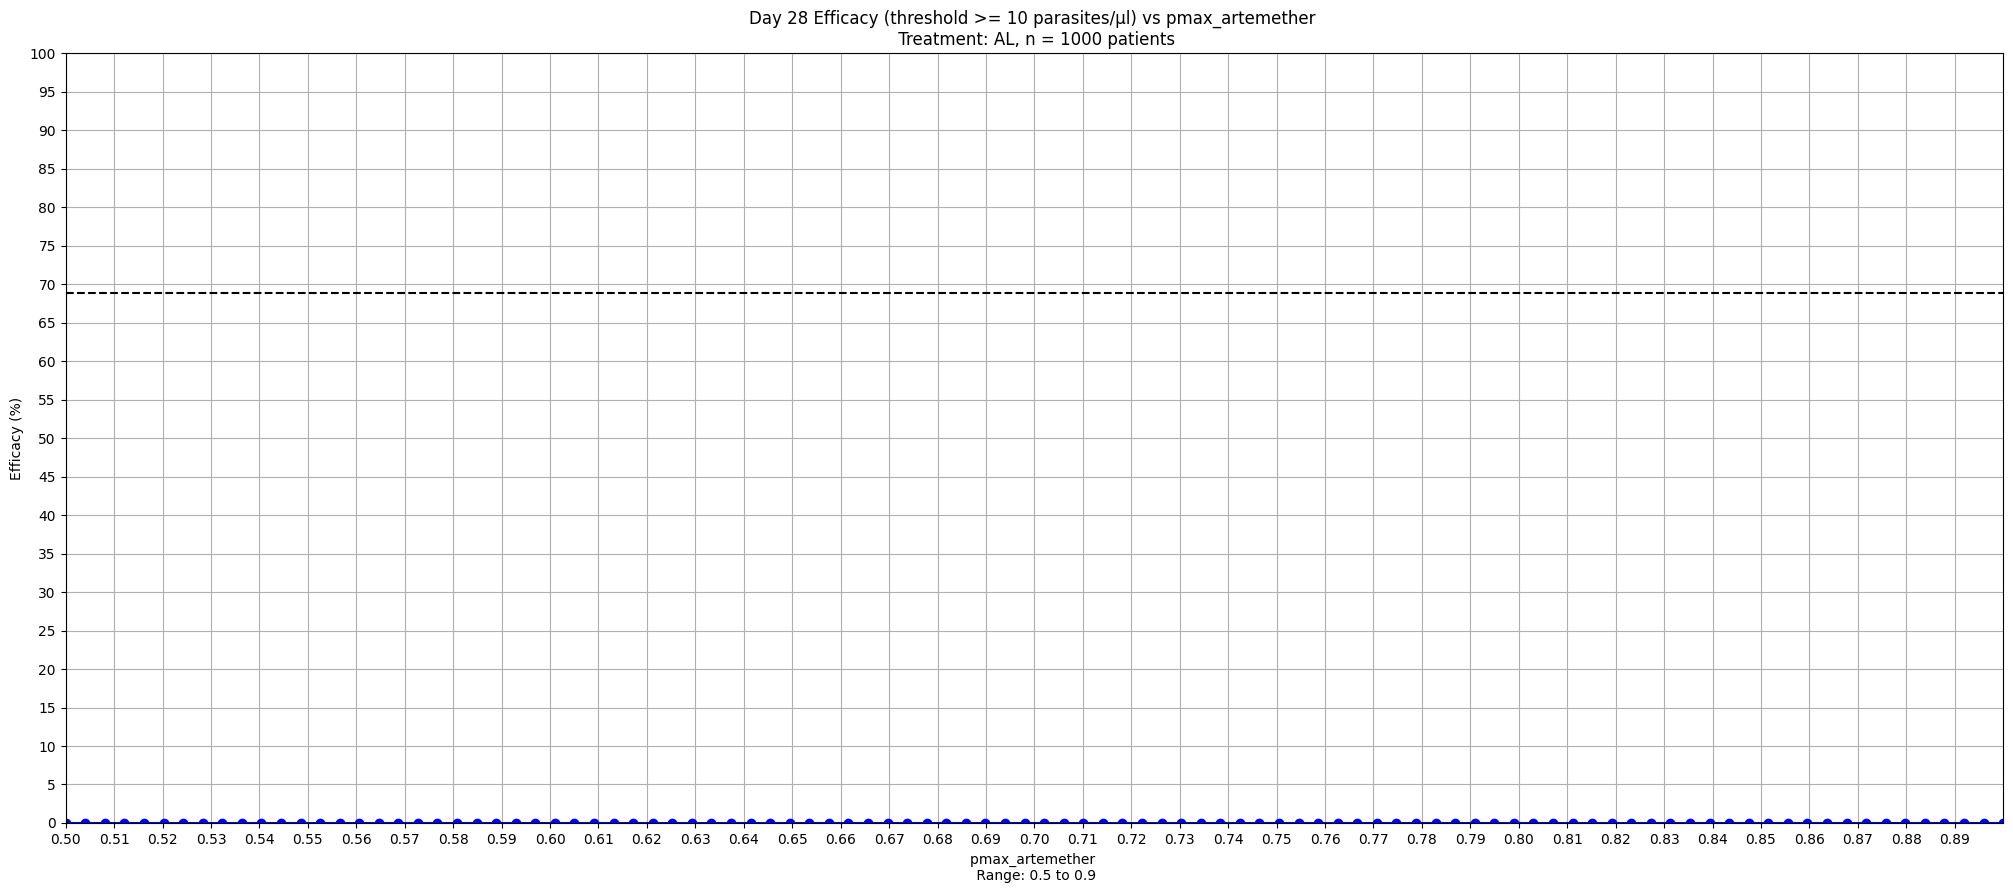

In [7]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, efficacy_values, marker='o', linestyle='-', color='b')
plt.xlabel(f'pmax_artemether \n Range: {min(pmax_values)} to {max(pmax_values)}')
plt.ylabel('Efficacy (%)')
plt.title(f"Day 28 Efficacy (threshold >= 10 parasites/μl) vs pmax_artemether \n Treatment: AL, n = {n_patients} patients")
plt.grid(True)
plt.xlim(min(pmax_values), max(pmax_values))  # Set x-axis limits
plt.xticks(np.arange(min(pmax_values), max(pmax_values),0.01))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=68.8, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig(f"pkpd_AL_{file_suffix}.png")  # Save the plot as a PNG file
plt.show()

### Function call to examine state values of one weight group

In [10]:
# Function to run a single simulation for a given weight value

def run_single_weight_simulation(weight):
    start_time = time.monotonic()
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "1000",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split() for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        
        end_time = time.monotonic()
        today = datetime.date.today()
        print("\nToday's date: ", today, "\n")
        print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

        return efficacy, df_weight, failed_treatment_count
        
    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

In [11]:
# Define the weight values to use
weight_values = [10, 15, 20, 30, 40, 50]
#weight_values = [10]

# File suffix for saving results
file_suffix = "_blood_volume_lum"

for weight in weight_values:

        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg_{file_suffix}.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg_{file_suffix}.csv", index=False)

        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")



Today's date:  2025-06-03 

Length of simulation:  0:00:26.065700 


The failed treatment count for weight 10kg is: 846

The percentage efficacy for weight 10kg is: 15.400000000000006 


Today's date:  2025-06-03 

Length of simulation:  0:00:26.108077 


The failed treatment count for weight 15kg is: 592

The percentage efficacy for weight 15kg is: 40.800000000000004 


Today's date:  2025-06-03 

Length of simulation:  0:00:26.646313 


The failed treatment count for weight 20kg is: 533

The percentage efficacy for weight 20kg is: 46.699999999999996 


Today's date:  2025-06-03 

Length of simulation:  0:00:25.268685 


The failed treatment count for weight 30kg is: 322

The percentage efficacy for weight 30kg is: 67.8 


Today's date:  2025-06-03 

Length of simulation:  0:00:25.450037 


The failed treatment count for weight 40kg is: 207

The percentage efficacy for weight 40kg is: 79.3 


Today's date:  2025-06-03 

Length of simulation:  0:00:25.082754 


The failed treatment co

In [12]:
# Load the dataframes
# Calculate the efficacy for each weight group

failed_treatment_count = []
efficacy = []
df_weight_compiled = []

for weight in [10, 20, 30, 40, 50]:
    # Load the dataframe
    df_weight = pd.read_pickle(f"df_weight_{weight}kg_{file_suffix}.pyobj")
    # Calculate the efficacy
    failed_treatment_count.append(df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0])
    total_patients = df_weight['PID'].nunique()
    efficacy.append((1 - (failed_treatment_count[-1] / total_patients)) * 100 if total_patients > 0 else np.nan)
    # Append the dataframe to the list
    df_weight_compiled.append(df_weight)
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Weight': [10, 20, 30, 40, 50],
    'Failed Treatment Count': failed_treatment_count,
    'Efficacy': efficacy
})

# Save the results to a CSV file
results_df.to_csv(f"efficacy_results_compiled_{file_suffix}.csv", index=False)
# Save the results to a pickle file
results_df.to_pickle(f"efficacy_results_compiled_{file_suffix}.pyobj")
# Print the results
print("\nEfficacy Results:")
print(results_df)
 


Efficacy Results:
   Weight  Failed Treatment Count  Efficacy
0      10                     846      15.4
1      20                     533      46.7
2      30                     322      67.8
3      40                     207      79.3
4      50                     188      81.2


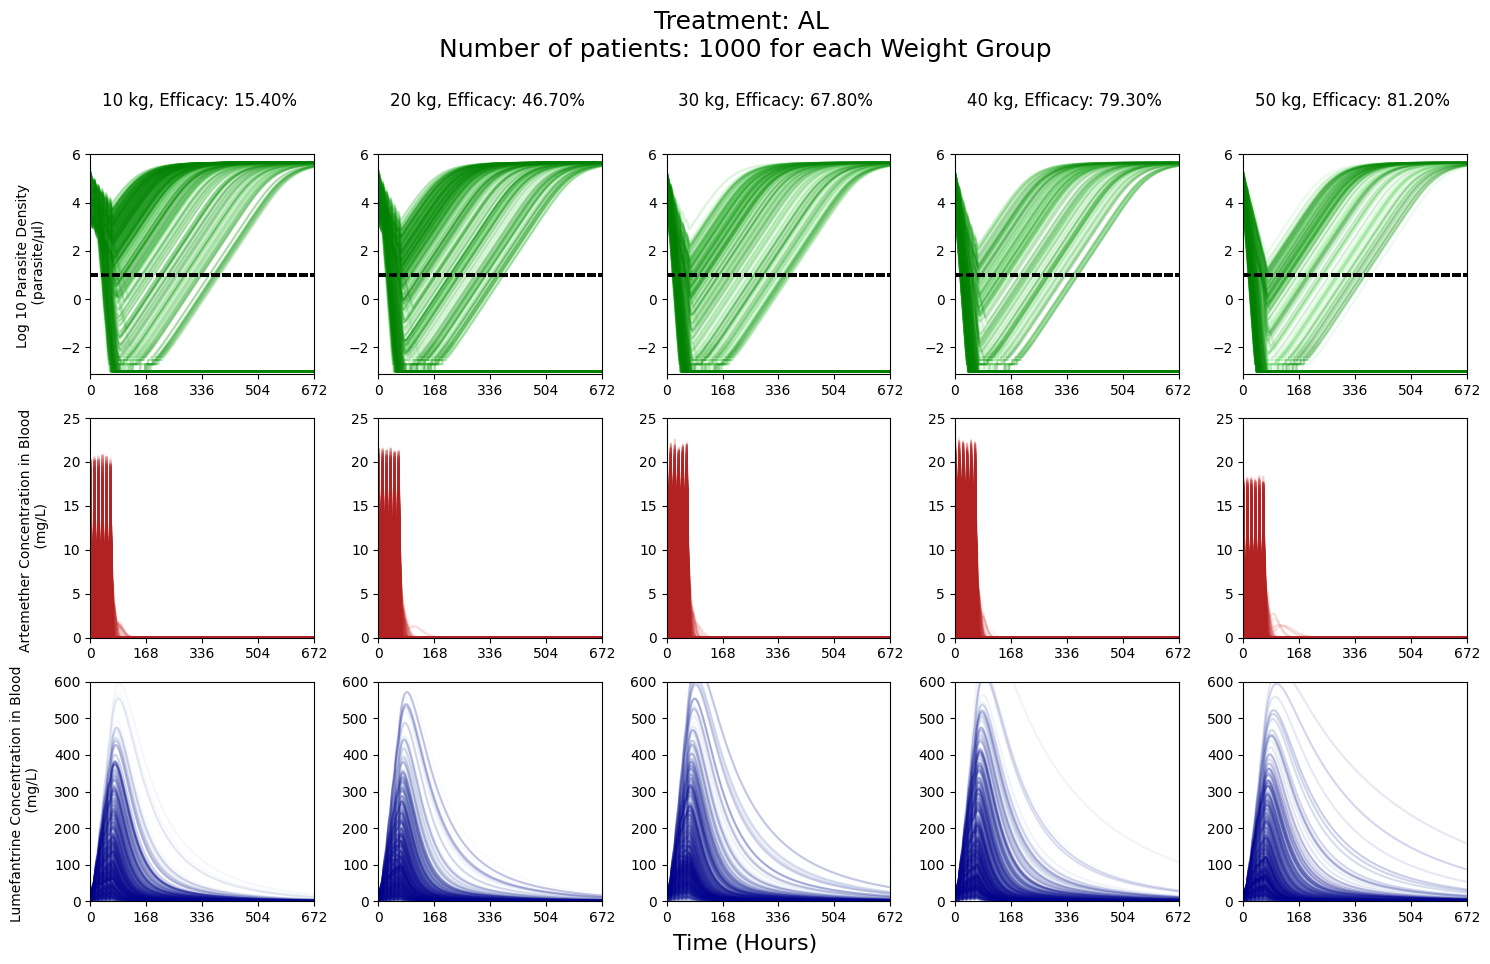

In [32]:
import math
from matplotlib.colors import LinearSegmentedColormap

if len(df_weight_compiled) >= 5:
    df_dict = {10: df_weight_compiled[0], 20: df_weight_compiled[1], 30: df_weight_compiled[2], 40: df_weight_compiled[3], 50: df_weight_compiled[4]}
else:
    print("Error: df_weight_compiled does not have enough elements.")

# Create a 4x3 subplot (3 variables, 5 weightgroups)
fig, ax = plt.subplots(3, 5, figsize=(15, 10), sharex=True, sharey=False)

# Define colormaps for each plot
green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["white", "lightgreen", "green"])  # Softer green for Parasite Density
red_cmap = LinearSegmentedColormap.from_list("red_cmap", ["white", "lightcoral", "firebrick"])  # Softer red for Artemether
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["white", "lightsteelblue", "darkblue"])  # Softer blue for Lumefantrine

# Iterate over weight groups
for i, weight in enumerate([10, 20, 30, 40, 50]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid].copy()
        df_pid['LOG10_PARASITEDENSITY'] = np.log10(df_pid['PARASITEDENSITY'] + 0.001)
        color = green_cmap(norm(j))
        ax[0, i].plot(df_pid['HOUR'], df_pid['LOG10_PARASITEDENSITY'], color=color, alpha=0.25)
        ax[0, i].set_ylim(-3.1, 6)  # Set y-axis limits for Parasite Density
        ax[0, i].axhline(y=np.log10(10), color='black', linestyle='--') 

  
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = red_cmap(norm(j))
        ax[1, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
        ax[1, i].set_ylim(0, 25)
        ax[2, i].set_yticks(range(0, 30, 5)) 

    # Plot Lumefantrine Concentration (Row 3) with blue colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = blue_cmap(norm(j))
        ax[2, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
        ax[2, i].set_ylim(0, 600)
        ax[2, i].set_yticks(range(0, 700, 100))  
    

    # Set x-axis limits
    for j in range(3):  # Iterate over rows (0, 1, 2)
        ax[j, i].set_xlim(0, 672)
        ax[j, i].set_xticks(range(0, 673, 168))

    # Set row labels on the top row
    ax[0, i].set_title(f'{weight} kg, Efficacy: {results_df[results_df["Weight"] == weight]["Efficacy"].values[0]:.2f}% \n ', fontsize=12, pad=20)

# Set **row titles** (only for the leftmost column)
row_titles = ["Log 10 Parasite Density \n (parasite/μl)", "Artemether Concentration in Blood \n (mg/L)", "Lumefantrine Concentration in Blood \n (mg/L)"]
for j in range(3):
    ax[j, 0].set_ylabel(row_titles[j], fontsize=10, rotation=90, labelpad=10)

# Set x-ticks for all subplots
for i in range(3):  
    for j in range(5):
        ax[i, j].tick_params(labelbottom=True)

fig.text(0.5, 0.04, 'Time (Hours)', ha='center', fontsize=16)

fig.suptitle(f"Treatment: AL \nNumber of patients: {num_pids} for each Weight Group", fontsize=18)

plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust layout to fit common x-label
plt.savefig(f"df_weight_efficacy_{file_suffix}.png")
plt.show()


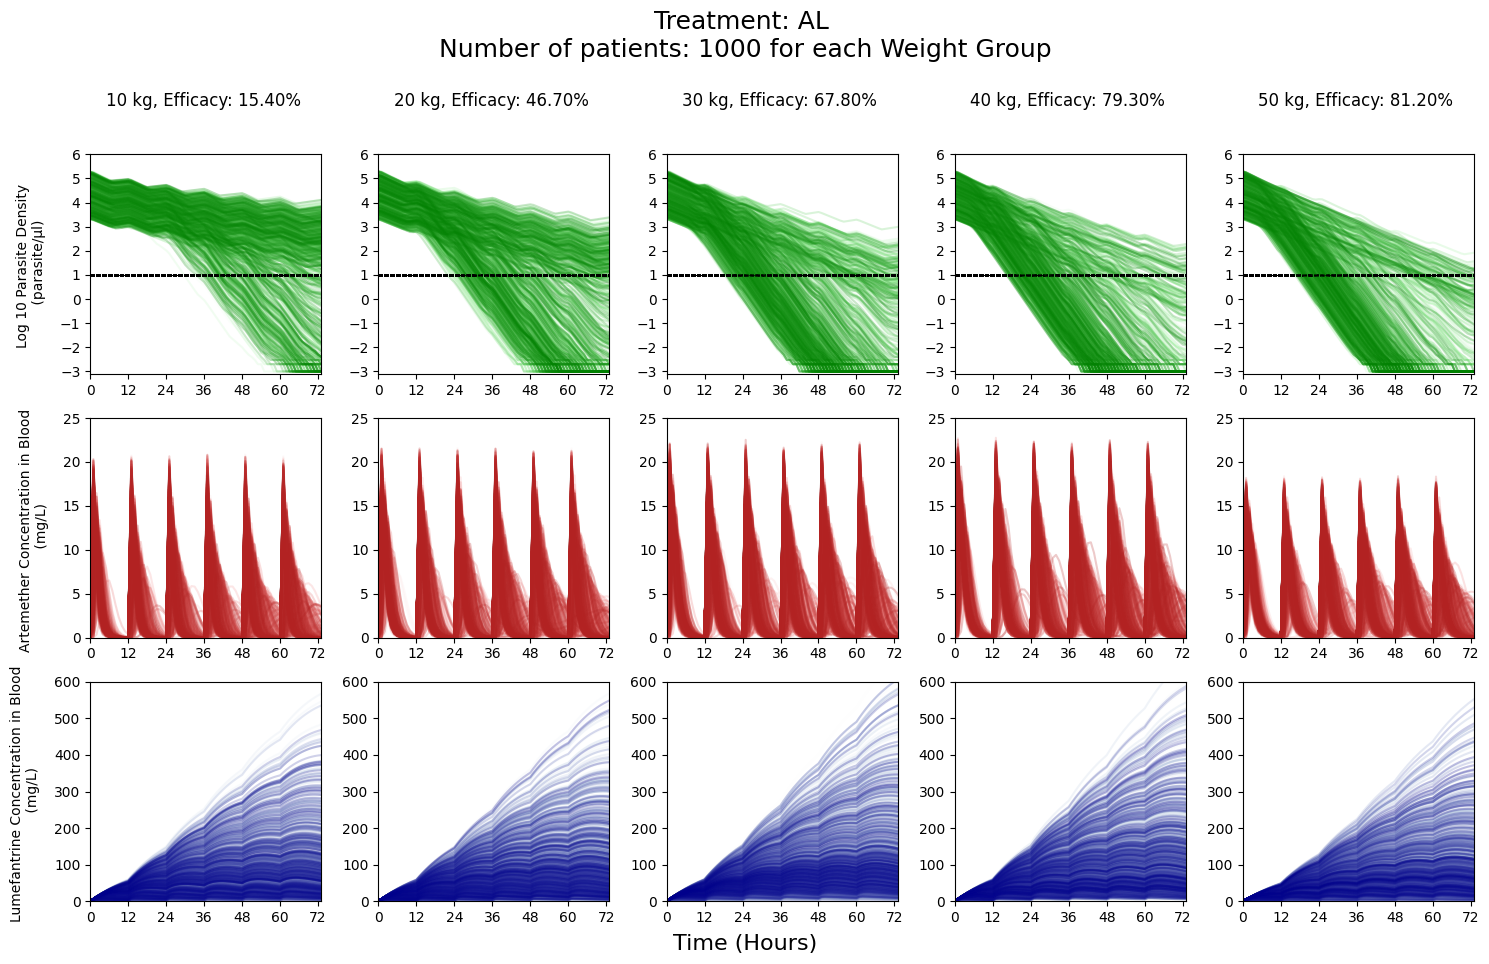

In [39]:
import math
from matplotlib.colors import LinearSegmentedColormap

if len(df_weight_compiled) >= 5:
    df_dict = {10: df_weight_compiled[0], 20: df_weight_compiled[1], 30: df_weight_compiled[2], 40: df_weight_compiled[3], 50: df_weight_compiled[4]}
else:
    print("Error: df_weight_compiled does not have enough elements.")

# Create a 4x3 subplot (3 variables, 5 weightgroups)
fig, ax = plt.subplots(3, 5, figsize=(15, 10), sharex=True, sharey=False)

# Define colormaps for each plot
green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["white", "lightgreen", "green"])  # Softer green for Parasite Density
red_cmap = LinearSegmentedColormap.from_list("red_cmap", ["white", "lightcoral", "firebrick"])  # Softer red for Artemether
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["white", "lightsteelblue", "darkblue"])  # Softer blue for Lumefantrine

# Iterate over weight groups
for i, weight in enumerate([10, 20, 30, 40, 50]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid].copy()
        df_pid['LOG10_PARASITEDENSITY'] = np.log10(df_pid['PARASITEDENSITY'] + 0.001)
        color = green_cmap(norm(j))
        ax[0, i].plot(df_pid['HOUR'], df_pid['LOG10_PARASITEDENSITY'], color=color, alpha=0.25)
        ax[0, i].set_ylim(-3.1, 6)  # Set y-axis limits for Parasite Density
        ax[0, i].set_yticks(range(-3, 7, 1)) 
        ax[0, i].axhline(y=np.log10(10), color='black', linestyle='--', linewidth=0.8, alpha=0.25)
  
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = red_cmap(norm(j))
        ax[1, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
        ax[1, i].set_ylim(0, 25)
        ax[2, i].set_yticks(range(0, 30, 5)) 

    # Plot Lumefantrine Concentration (Row 3) with blue colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = blue_cmap(norm(j))
        ax[2, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
        ax[2, i].set_ylim(0, 600)
        ax[2, i].set_yticks(range(0, 700, 100))  
    

    # Set x-axis limits
    for j in range(3):  # Iterate over rows (0, 1, 2)
        ax[j, i].set_xlim(0, (24*3)+1)
        ax[j, i].set_xticks(range(0, 73, 12))

    # Set row labels on the top row
    ax[0, i].set_title(f'{weight} kg, Efficacy: {results_df[results_df["Weight"] == weight]["Efficacy"].values[0]:.2f}% \n ', fontsize=12, pad=20)

# Set **row titles** (only for the leftmost column)
row_titles = ["Log 10 Parasite Density \n (parasite/μl)", "Artemether Concentration in Blood \n (mg/L)", "Lumefantrine Concentration in Blood \n (mg/L)"]
for j in range(3):
    ax[j, 0].set_ylabel(row_titles[j], fontsize=10, rotation=90, labelpad=10)

# Set x-ticks for all subplots
for i in range(3):  
    for j in range(5):
        ax[i, j].tick_params(labelbottom=True)

fig.text(0.5, 0.04, 'Time (Hours)', ha='center', fontsize=16)

fig.suptitle(f"Treatment: AL \nNumber of patients: {num_pids} for each Weight Group", fontsize=18)

plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust layout to fit common x-label
plt.savefig(f"df_weight_efficacy_{file_suffix}_72h.png")
plt.show()


In [11]:
# Define the range for pmax_artemether
min_pmax = 0.9
max_pmax = 0.99

# Define weight_art values
pmax_values = np.linspace(min_pmax, max_pmax, 101) 

# Initialize a grid to store the clearance rates
efficacy_values = np.zeros(len(pmax_values))
failed_treatment_count_values = np.zeros(len(pmax_values))

print(pmax_values)

[0.9    0.9009 0.9018 0.9027 0.9036 0.9045 0.9054 0.9063 0.9072 0.9081
 0.909  0.9099 0.9108 0.9117 0.9126 0.9135 0.9144 0.9153 0.9162 0.9171
 0.918  0.9189 0.9198 0.9207 0.9216 0.9225 0.9234 0.9243 0.9252 0.9261
 0.927  0.9279 0.9288 0.9297 0.9306 0.9315 0.9324 0.9333 0.9342 0.9351
 0.936  0.9369 0.9378 0.9387 0.9396 0.9405 0.9414 0.9423 0.9432 0.9441
 0.945  0.9459 0.9468 0.9477 0.9486 0.9495 0.9504 0.9513 0.9522 0.9531
 0.954  0.9549 0.9558 0.9567 0.9576 0.9585 0.9594 0.9603 0.9612 0.9621
 0.963  0.9639 0.9648 0.9657 0.9666 0.9675 0.9684 0.9693 0.9702 0.9711
 0.972  0.9729 0.9738 0.9747 0.9756 0.9765 0.9774 0.9783 0.9792 0.9801
 0.981  0.9819 0.9828 0.9837 0.9846 0.9855 0.9864 0.9873 0.9882 0.9891
 0.99  ]


In [12]:
def run_simulation_pmax_artemether_adj(idx, pmax_artemether, n_patients):
    command_pmax_artemether = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", str(n_patients),
        "--weight", "54",
        "--pmax_artemether", str(pmax_artemether),
        "--pmax_lum", "0",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_pmax_artemether = subprocess.run(command_pmax_artemether, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmax_artemether = output_pmax_artemether.stdout.splitlines()
        df_pmax_artemether = pd.DataFrame(
            [line.split() for line in lines_pmax_artemether],
            columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_pmax_artemether = df_pmax_artemether.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_pmax_artemether[df_pmax_artemether['PARASITEDENSITY'] >= 10].shape[0]
        total_patients = df_pmax_artemether['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_pmax_artemether)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for pmax_artemether: {pmax_artemether}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

    except Exception as e:
        print(f"An unexpected error occurred for pmax_artemether: {pmax_artemether}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

In [14]:

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

n_patients = 1000  # Number of patients for each simulation
file_suffix = "artemether_monotherapy_calibration_02"

# Prepare a list of parameters to pass to the pool
params_list = [(i, pmax_values[i], n_patients) for i in range(len(pmax_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation_pmax_artemether_adj, params_list):
            idx, efficacy, df_pmax_artemether = result
            results.append((idx, efficacy, df_pmax_artemether))
            if df_pmax_artemether is not None:
                dfs.append(df_pmax_artemether)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy, df_pmax_artemether in results:
    efficacy_values[idx] = efficacy

# Create a DataFrame with pmax_artemether_values and clearance_rates
df = pd.DataFrame({
    'pmax_artemether': pmax_values,
    'Efficacy': efficacy_values
})

# Save the DataFrame to a pickle file
df.to_pickle(f"pkpd_AL_{file_suffix}.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle(f"pkpd_AL_{file_suffix}.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv(f"pkpd_AL_{file_suffix}.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 101/101 [05:28<00:00,  3.25s/it] 

DataFrame saved as pickle and CSV files successfully.


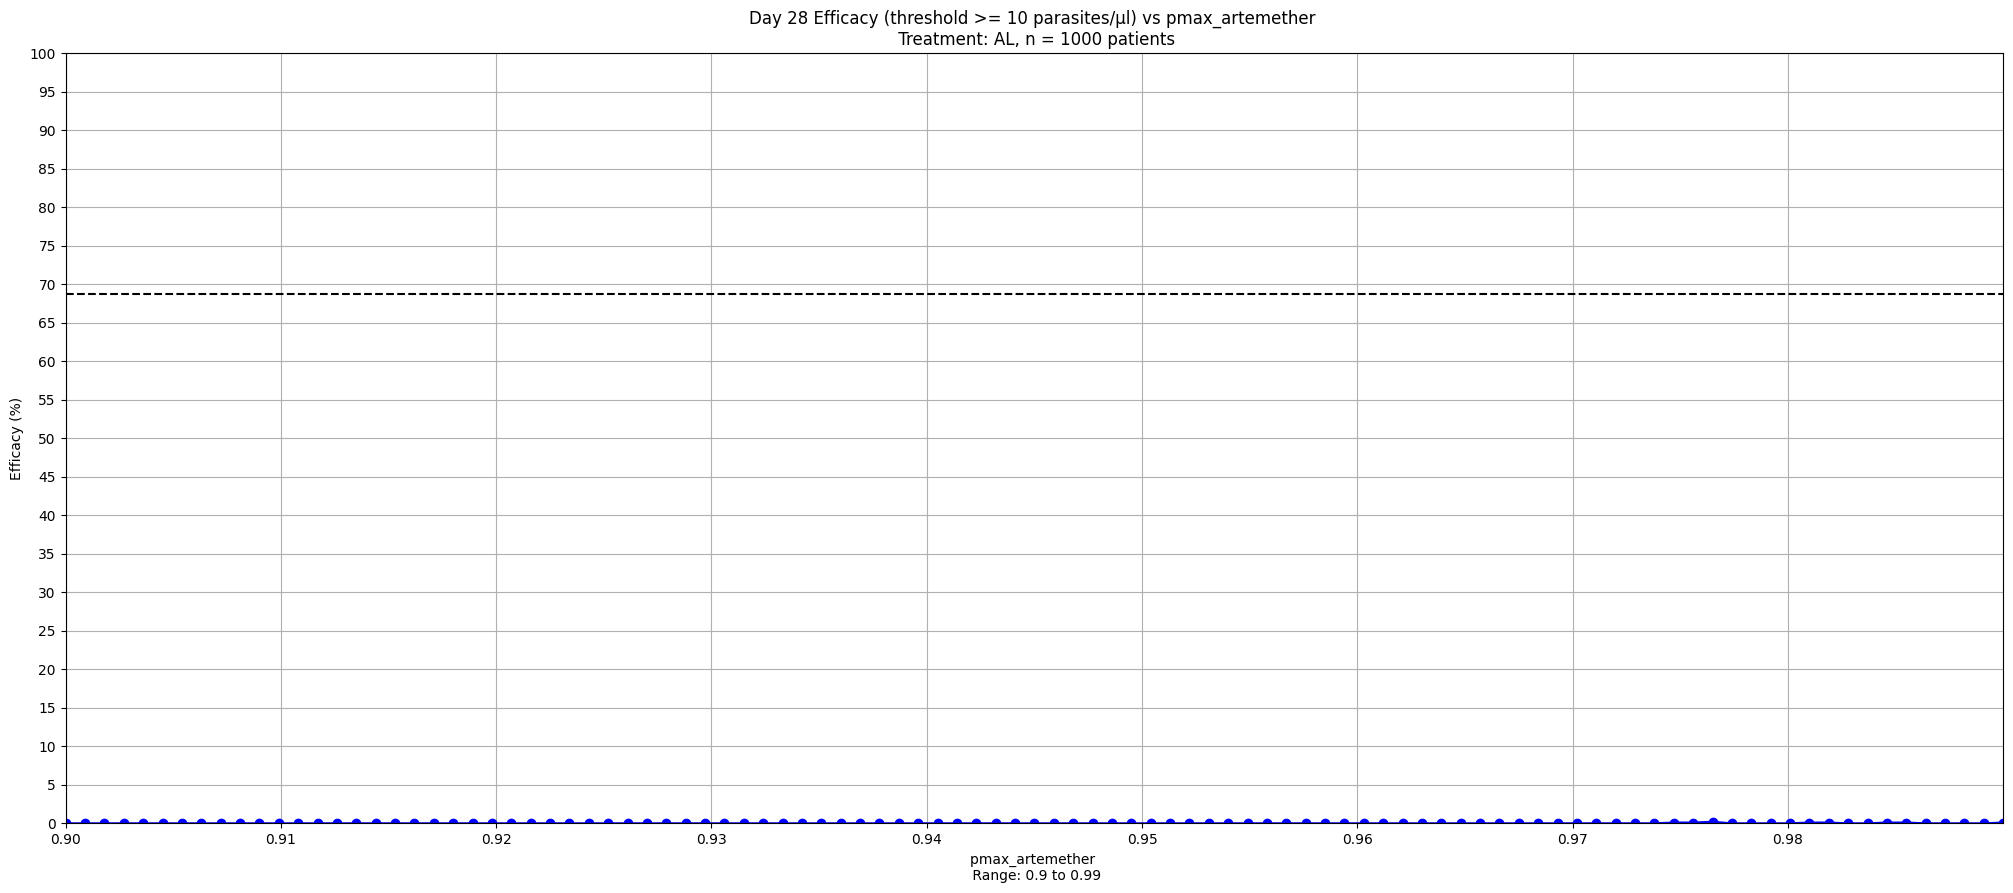

In [19]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, efficacy_values, marker='o', linestyle='-', color='b')
plt.xlabel(f'pmax_artemether \n Range: {min(pmax_values)} to {max(pmax_values)}')
plt.ylabel('Efficacy (%)')
plt.title(f"Day 28 Efficacy (threshold >= 10 parasites/μl) vs pmax_artemether \n Treatment: AL, n = {n_patients} patients")
plt.grid(True)
plt.xlim(min(pmax_values), max(pmax_values))  # Set x-axis limits
plt.xticks(np.arange(min(pmax_values), max(pmax_values),0.01))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=68.8, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig(f"pkpd_AL_{file_suffix}.png")  # Save the plot as a PNG file
plt.show()

In [26]:
# Define the range for pmax_artemether
min_pmax = 0.99
max_pmax = 0.999

# Define weight_art values
pmax_values = np.linspace(min_pmax, max_pmax, 101) 

# Initialize a grid to store the clearance rates
efficacy_values = np.zeros(len(pmax_values))
failed_treatment_count_values = np.zeros(len(pmax_values))

print(pmax_values)

[0.99    0.99009 0.99018 0.99027 0.99036 0.99045 0.99054 0.99063 0.99072
 0.99081 0.9909  0.99099 0.99108 0.99117 0.99126 0.99135 0.99144 0.99153
 0.99162 0.99171 0.9918  0.99189 0.99198 0.99207 0.99216 0.99225 0.99234
 0.99243 0.99252 0.99261 0.9927  0.99279 0.99288 0.99297 0.99306 0.99315
 0.99324 0.99333 0.99342 0.99351 0.9936  0.99369 0.99378 0.99387 0.99396
 0.99405 0.99414 0.99423 0.99432 0.99441 0.9945  0.99459 0.99468 0.99477
 0.99486 0.99495 0.99504 0.99513 0.99522 0.99531 0.9954  0.99549 0.99558
 0.99567 0.99576 0.99585 0.99594 0.99603 0.99612 0.99621 0.9963  0.99639
 0.99648 0.99657 0.99666 0.99675 0.99684 0.99693 0.99702 0.99711 0.9972
 0.99729 0.99738 0.99747 0.99756 0.99765 0.99774 0.99783 0.99792 0.99801
 0.9981  0.99819 0.99828 0.99837 0.99846 0.99855 0.99864 0.99873 0.99882
 0.99891 0.999  ]


In [27]:
def run_simulation_pmax_artemether_adj(idx, pmax_artemether, n_patients):
    command_pmax_artemether = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", str(n_patients),
        "--weight", "54",
        "--pmax_artemether", str(pmax_artemether),
        "--pmax_lum", "0",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_pmax_artemether = subprocess.run(command_pmax_artemether, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmax_artemether = output_pmax_artemether.stdout.splitlines()
        df_pmax_artemether = pd.DataFrame(
            [line.split() for line in lines_pmax_artemether],
            columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_pmax_artemether = df_pmax_artemether.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_pmax_artemether[df_pmax_artemether['PARASITEDENSITY'] >= 10].shape[0]
        total_patients = df_pmax_artemether['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_pmax_artemether)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for pmax_artemether: {pmax_artemether}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

    except Exception as e:
        print(f"An unexpected error occurred for pmax_artemether: {pmax_artemether}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

In [28]:

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

n_patients = 1000  # Number of patients for each simulation
file_suffix = "artemether_monotherapy_calibration_03"

# Prepare a list of parameters to pass to the pool
params_list = [(i, pmax_values[i], n_patients) for i in range(len(pmax_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation_pmax_artemether_adj, params_list):
            idx, efficacy, df_pmax_artemether = result
            results.append((idx, efficacy, df_pmax_artemether))
            if df_pmax_artemether is not None:
                dfs.append(df_pmax_artemether)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy, df_pmax_artemether in results:
    efficacy_values[idx] = efficacy

# Create a DataFrame with pmax_artemether_values and clearance_rates
df = pd.DataFrame({
    'pmax_artemether': pmax_values,
    'Efficacy': efficacy_values
})

# Save the DataFrame to a pickle file
df.to_pickle(f"pkpd_AL_{file_suffix}.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle(f"pkpd_AL_{file_suffix}.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv(f"pkpd_AL_{file_suffix}.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 101/101 [05:23<00:00,  3.21s/it] 

DataFrame saved as pickle and CSV files successfully.


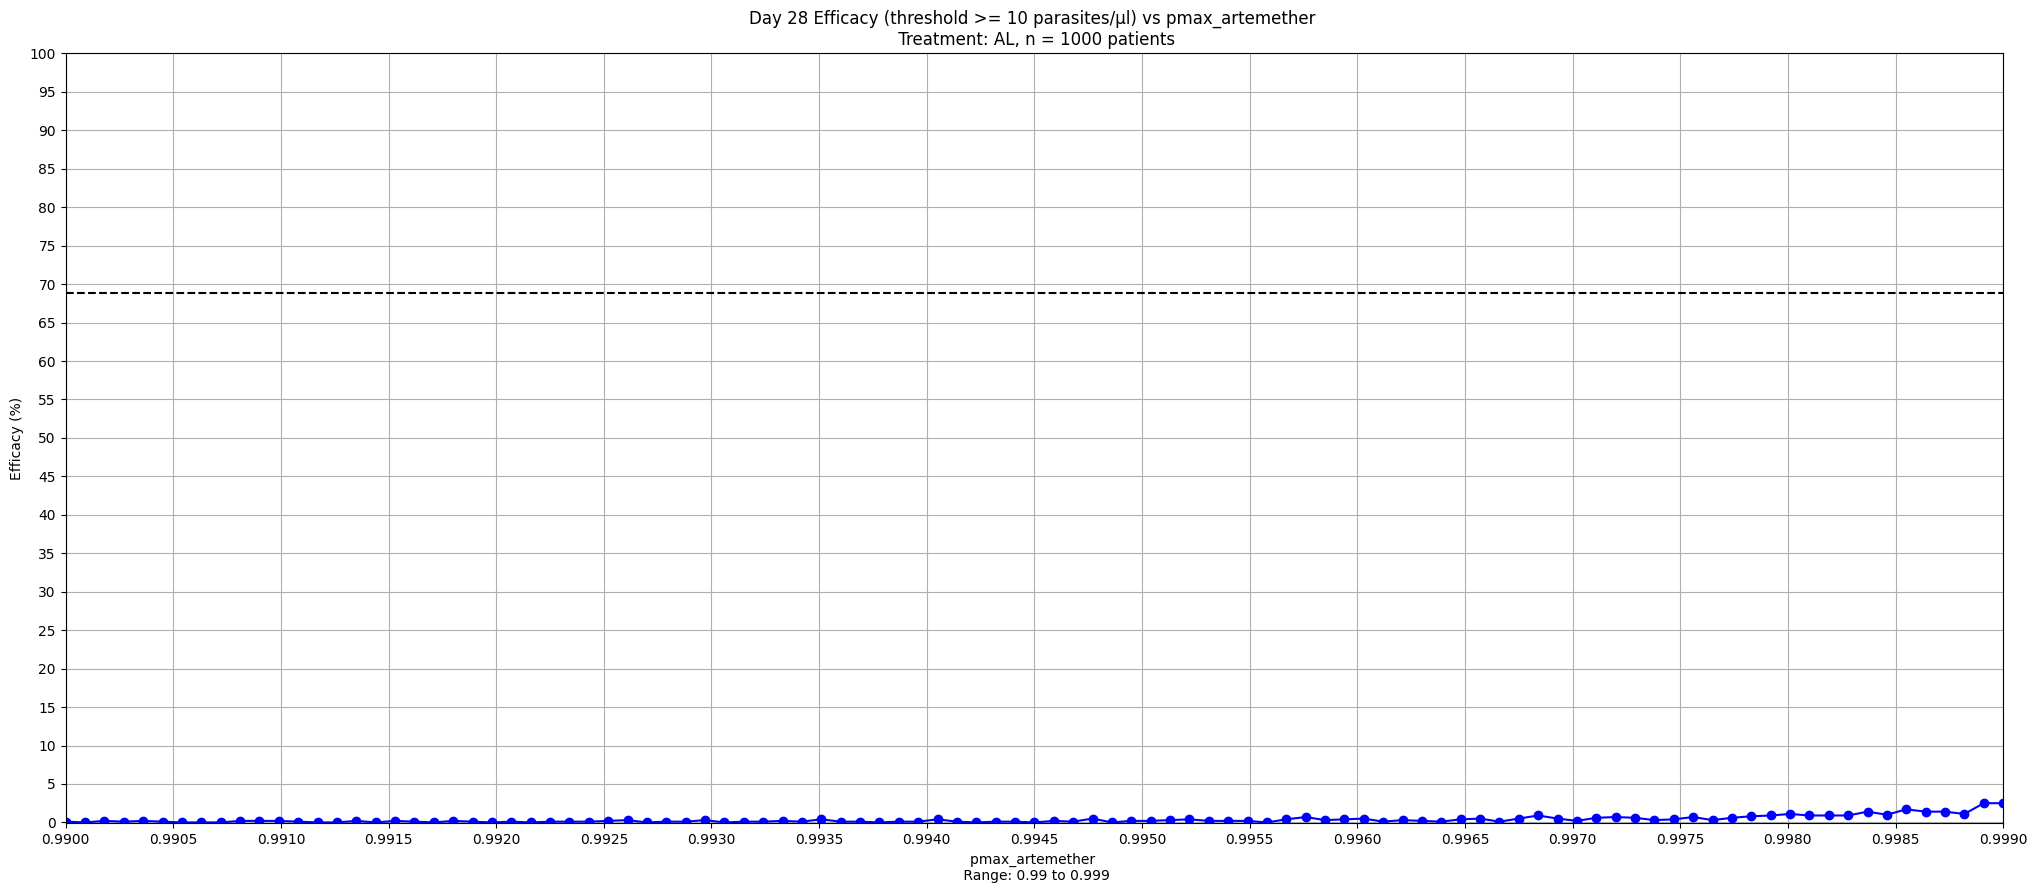

In [40]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, efficacy_values, marker='o', linestyle='-', color='b')
plt.xlabel(f'pmax_artemether \n Range: {min(pmax_values)} to {max(pmax_values)}')
plt.ylabel('Efficacy (%)')
plt.title(f"Day 28 Efficacy (threshold >= 10 parasites/μl) vs pmax_artemether \n Treatment: AL, n = {n_patients} patients")
plt.grid(True)
plt.xlim(min(pmax_values), max(pmax_values))  # Set x-axis limits
plt.xticks(np.arange(min(pmax_values), max(pmax_values),0.0005))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=68.8, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig(f"pkpd_AL_{file_suffix}.png")  # Save the plot as a PNG file
plt.show()

In [ ]:
# Define the range for pmax_artemether
min_pmax = 0.999
max_pmax = 0.9999

# Define weight_art values
pmax_values = np.linspace(min_pmax, max_pmax, 101) 

# Initialize a grid to store the clearance rates
efficacy_values = np.zeros(len(pmax_values))
failed_treatment_count_values = np.zeros(len(pmax_values))

print(pmax_values)

[0.999     0.9990099 0.9990198 0.9990297 0.9990396 0.9990495 0.9990594
 0.9990693 0.9990792 0.9990891 0.999099  0.9991089 0.9991188 0.9991287
 0.9991386 0.9991485 0.9991584 0.9991683 0.9991782 0.9991881 0.999198
 0.9992079 0.9992178 0.9992277 0.9992376 0.9992475 0.9992574 0.9992673
 0.9992772 0.9992871 0.999297  0.9993069 0.9993168 0.9993267 0.9993366
 0.9993465 0.9993564 0.9993663 0.9993762 0.9993861 0.999396  0.9994059
 0.9994158 0.9994257 0.9994356 0.9994455 0.9994554 0.9994653 0.9994752
 0.9994851 0.999495  0.9995049 0.9995148 0.9995247 0.9995346 0.9995445
 0.9995544 0.9995643 0.9995742 0.9995841 0.999594  0.9996039 0.9996138
 0.9996237 0.9996336 0.9996435 0.9996534 0.9996633 0.9996732 0.9996831
 0.999693  0.9997029 0.9997128 0.9997227 0.9997326 0.9997425 0.9997524
 0.9997623 0.9997722 0.9997821 0.999792  0.9998019 0.9998118 0.9998217
 0.9998316 0.9998415 0.9998514 0.9998613 0.9998712 0.9998811 0.999891
 0.9999009 0.9999108 0.9999207 0.9999306 0.9999405 0.9999504 0.9999603
 0.99997

In [45]:
def run_simulation_pmax_artemether_adj(idx, pmax_artemether, n_patients):
    command_pmax_artemether = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", str(n_patients),
        "--weight", "54",
        "--pmax_artemether", str(pmax_artemether),
        "--pmax_lum", "0",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_pmax_artemether = subprocess.run(command_pmax_artemether, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmax_artemether = output_pmax_artemether.stdout.splitlines()
        df_pmax_artemether = pd.DataFrame(
            [line.split() for line in lines_pmax_artemether],
            columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_pmax_artemether = df_pmax_artemether.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_pmax_artemether[df_pmax_artemether['PARASITEDENSITY'] >= 10].shape[0]
        total_patients = df_pmax_artemether['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_pmax_artemether)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for pmax_artemether: {pmax_artemether}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

    except Exception as e:
        print(f"An unexpected error occurred for pmax_artemether: {pmax_artemether}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

In [46]:

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

n_patients = 1000  # Number of patients for each simulation
file_suffix = "artemether_monotherapy_calibration_04"

# Prepare a list of parameters to pass to the pool
params_list = [(i, pmax_values[i], n_patients) for i in range(len(pmax_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation_pmax_artemether_adj, params_list):
            idx, efficacy, df_pmax_artemether = result
            results.append((idx, efficacy, df_pmax_artemether))
            if df_pmax_artemether is not None:
                dfs.append(df_pmax_artemether)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy, df_pmax_artemether in results:
    efficacy_values[idx] = efficacy

# Create a DataFrame with pmax_artemether_values and clearance_rates
df = pd.DataFrame({
    'pmax_artemether': pmax_values,
    'Efficacy': efficacy_values
})

# Save the DataFrame to a pickle file
df.to_pickle(f"pkpd_AL_{file_suffix}.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle(f"pkpd_AL_{file_suffix}.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv(f"pkpd_AL_{file_suffix}.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 101/101 [05:15<00:00,  3.13s/it] 

DataFrame saved as pickle and CSV files successfully.


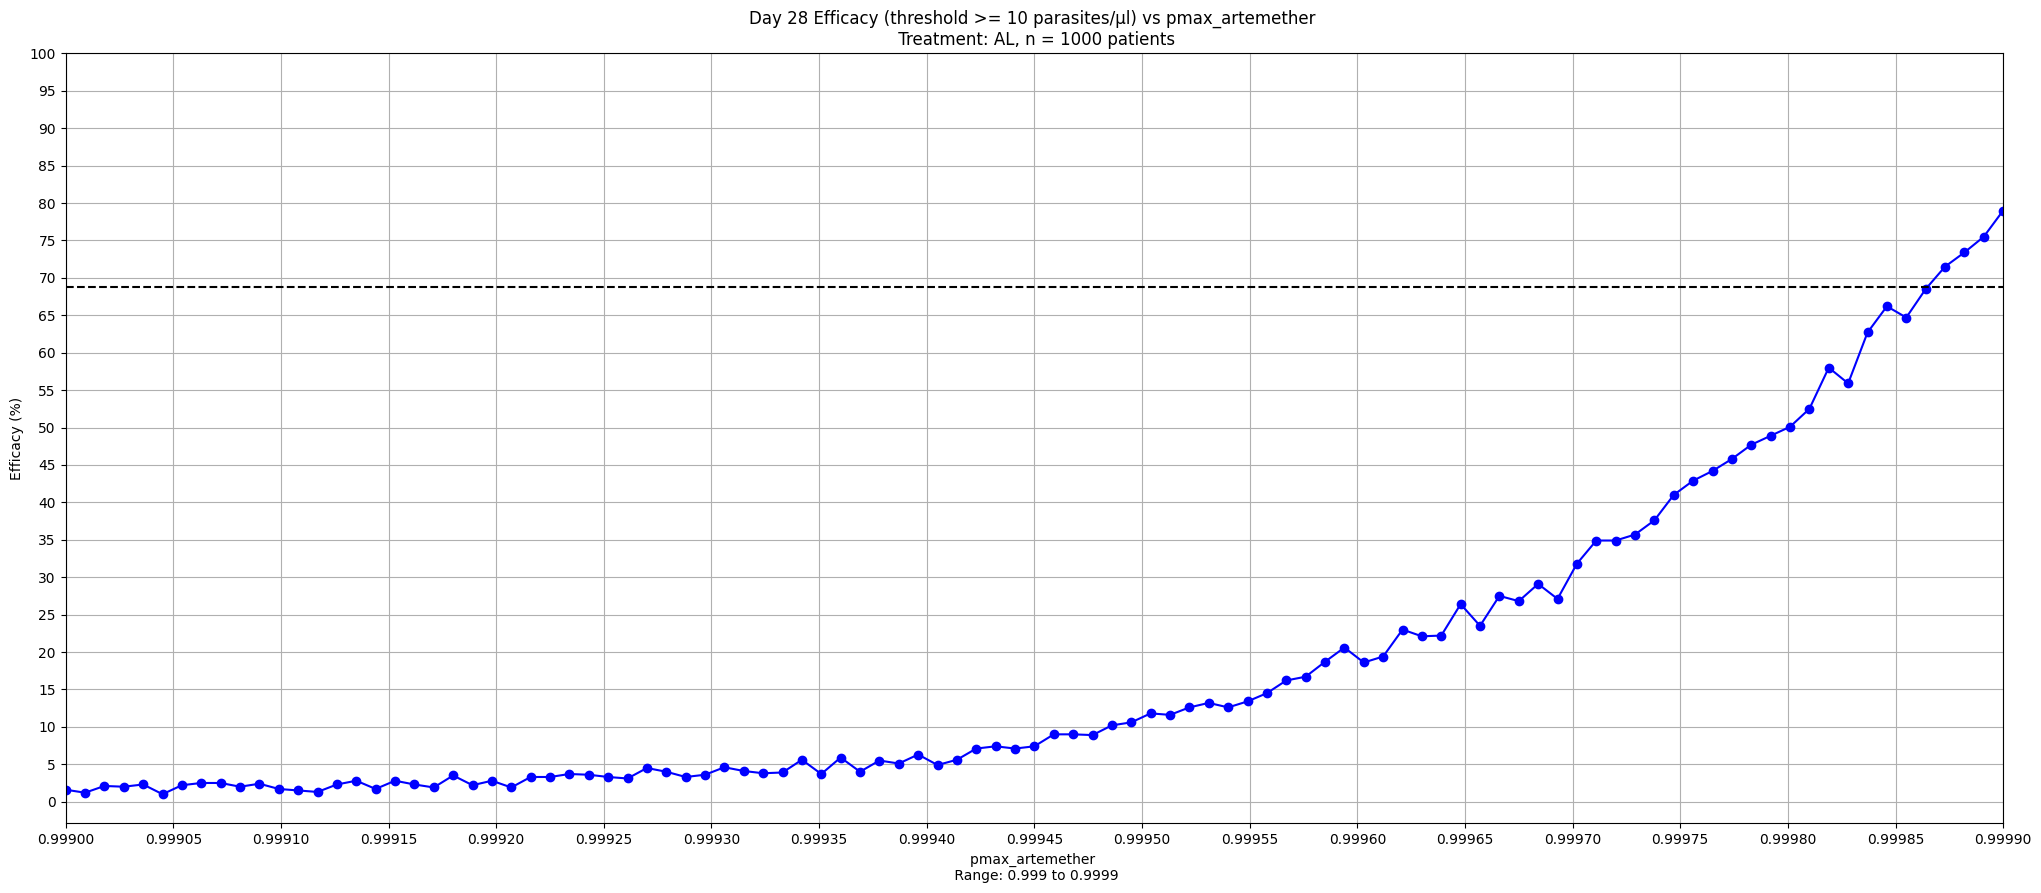

In [59]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, efficacy_values, marker='o', linestyle='-', color='b')
plt.xlabel(f'pmax_artemether \n Range: {min(pmax_values)} to {max(pmax_values)}')
plt.ylabel('Efficacy (%)')
plt.title(f"Day 28 Efficacy (threshold >= 10 parasites/μl) vs pmax_artemether \n Treatment: AL, n = {n_patients} patients")
plt.grid(True)
plt.xlim(min(pmax_values), max(pmax_values))  # Set x-axis limits
plt.xticks(np.arange(min(pmax_values), max(pmax_values),0.00005))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=68.8, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig(f"pkpd_AL_{file_suffix}.png")  # Save the plot as a PNG file
plt.show()

In [61]:
# Define the range for pmax_artemether
min_pmax = 0.999
max_pmax = 0.99999

# Define weight_art values
pmax_values = np.linspace(min_pmax, max_pmax, 101) 

# Initialize a grid to store the clearance rates
efficacy_values = np.zeros(len(pmax_values))
failed_treatment_count_values = np.zeros(len(pmax_values))

print(pmax_values)

[0.999     0.9990099 0.9990198 0.9990297 0.9990396 0.9990495 0.9990594
 0.9990693 0.9990792 0.9990891 0.999099  0.9991089 0.9991188 0.9991287
 0.9991386 0.9991485 0.9991584 0.9991683 0.9991782 0.9991881 0.999198
 0.9992079 0.9992178 0.9992277 0.9992376 0.9992475 0.9992574 0.9992673
 0.9992772 0.9992871 0.999297  0.9993069 0.9993168 0.9993267 0.9993366
 0.9993465 0.9993564 0.9993663 0.9993762 0.9993861 0.999396  0.9994059
 0.9994158 0.9994257 0.9994356 0.9994455 0.9994554 0.9994653 0.9994752
 0.9994851 0.999495  0.9995049 0.9995148 0.9995247 0.9995346 0.9995445
 0.9995544 0.9995643 0.9995742 0.9995841 0.999594  0.9996039 0.9996138
 0.9996237 0.9996336 0.9996435 0.9996534 0.9996633 0.9996732 0.9996831
 0.999693  0.9997029 0.9997128 0.9997227 0.9997326 0.9997425 0.9997524
 0.9997623 0.9997722 0.9997821 0.999792  0.9998019 0.9998118 0.9998217
 0.9998316 0.9998415 0.9998514 0.9998613 0.9998712 0.9998811 0.999891
 0.9999009 0.9999108 0.9999207 0.9999306 0.9999405 0.9999504 0.9999603
 0.99997

In [62]:
def run_simulation_pmax_artemether_adj(idx, pmax_artemether, n_patients):
    command_pmax_artemether = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", str(n_patients),
        "--weight", "54",
        "--pmax_artemether", str(pmax_artemether),
        "--pmax_lum", "0",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_pmax_artemether = subprocess.run(command_pmax_artemether, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmax_artemether = output_pmax_artemether.stdout.splitlines()
        df_pmax_artemether = pd.DataFrame(
            [line.split() for line in lines_pmax_artemether],
            columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_pmax_artemether = df_pmax_artemether.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_pmax_artemether[df_pmax_artemether['PARASITEDENSITY'] >= 10].shape[0]
        total_patients = df_pmax_artemether['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_pmax_artemether)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for pmax_artemether: {pmax_artemether}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

    except Exception as e:
        print(f"An unexpected error occurred for pmax_artemether: {pmax_artemether}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

In [63]:

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

n_patients = 1000  # Number of patients for each simulation
file_suffix = "artemether_monotherapy_calibration_05"

# Prepare a list of parameters to pass to the pool
params_list = [(i, pmax_values[i], n_patients) for i in range(len(pmax_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation_pmax_artemether_adj, params_list):
            idx, efficacy, df_pmax_artemether = result
            results.append((idx, efficacy, df_pmax_artemether))
            if df_pmax_artemether is not None:
                dfs.append(df_pmax_artemether)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy, df_pmax_artemether in results:
    efficacy_values[idx] = efficacy

# Create a DataFrame with pmax_artemether_values and clearance_rates
df = pd.DataFrame({
    'pmax_artemether': pmax_values,
    'Efficacy': efficacy_values
})

# Save the DataFrame to a pickle file
df.to_pickle(f"pkpd_AL_{file_suffix}.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle(f"pkpd_AL_{file_suffix}.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv(f"pkpd_AL_{file_suffix}.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 101/101 [05:20<00:00,  3.17s/it] 

DataFrame saved as pickle and CSV files successfully.


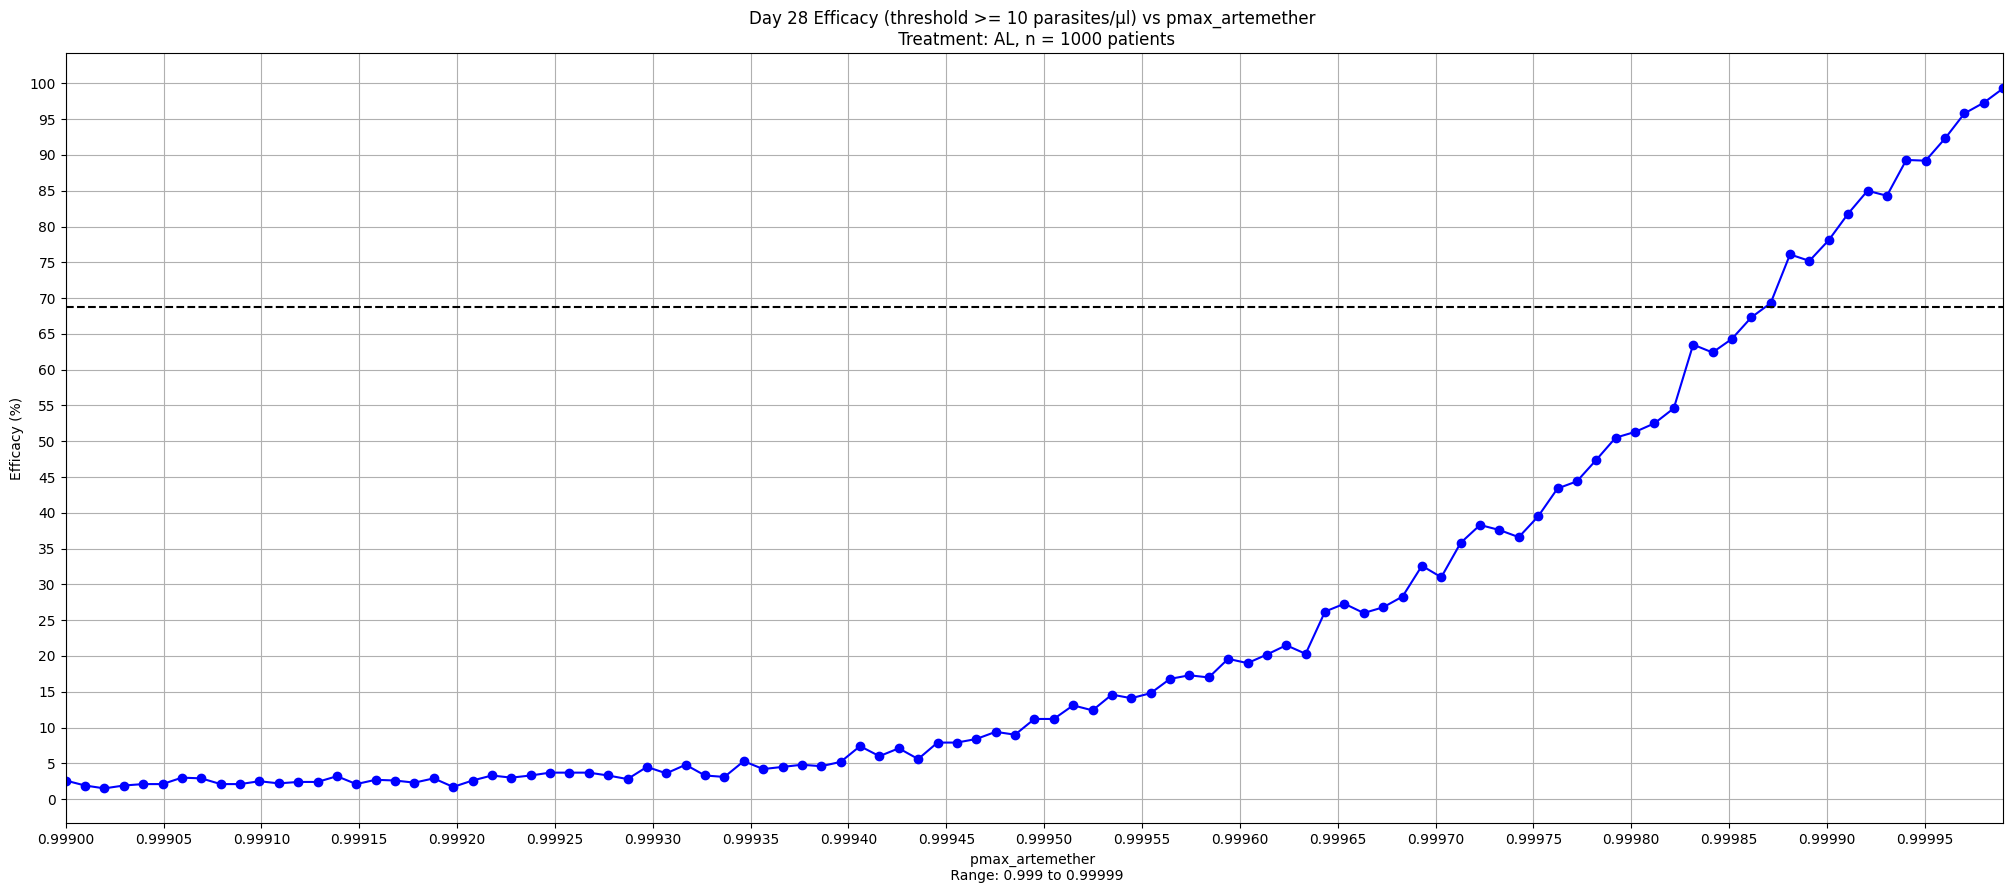

In [64]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, efficacy_values, marker='o', linestyle='-', color='b')
plt.xlabel(f'pmax_artemether \n Range: {min(pmax_values)} to {max(pmax_values)}')
plt.ylabel('Efficacy (%)')
plt.title(f"Day 28 Efficacy (threshold >= 10 parasites/μl) vs pmax_artemether \n Treatment: AL, n = {n_patients} patients")
plt.grid(True)
plt.xlim(min(pmax_values), max(pmax_values))  # Set x-axis limits
plt.xticks(np.arange(min(pmax_values), max(pmax_values),0.00005))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=68.8, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig(f"pkpd_AL_{file_suffix}.png")  # Save the plot as a PNG file
plt.show()

In [65]:
# Define the range for pmax_artemether
min_pmax = 0.999
max_pmax = 0.999999

# Define weight_art values
pmax_values = np.linspace(min_pmax, max_pmax, 101) 

# Initialize a grid to store the clearance rates
efficacy_values = np.zeros(len(pmax_values))
failed_treatment_count_values = np.zeros(len(pmax_values))

print(pmax_values)

[0.999      0.99900999 0.99901998 0.99902997 0.99903996 0.99904995
 0.99905994 0.99906993 0.99907992 0.99908991 0.9990999  0.99910989
 0.99911988 0.99912987 0.99913986 0.99914985 0.99915984 0.99916983
 0.99917982 0.99918981 0.9991998  0.99920979 0.99921978 0.99922977
 0.99923976 0.99924975 0.99925974 0.99926973 0.99927972 0.99928971
 0.9992997  0.99930969 0.99931968 0.99932967 0.99933966 0.99934965
 0.99935964 0.99936963 0.99937962 0.99938961 0.9993996  0.99940959
 0.99941958 0.99942957 0.99943956 0.99944955 0.99945954 0.99946953
 0.99947952 0.99948951 0.9994995  0.99950949 0.99951948 0.99952947
 0.99953946 0.99954945 0.99955944 0.99956943 0.99957942 0.99958941
 0.9995994  0.99960939 0.99961938 0.99962937 0.99963936 0.99964935
 0.99965934 0.99966933 0.99967932 0.99968931 0.9996993  0.99970929
 0.99971928 0.99972927 0.99973926 0.99974925 0.99975924 0.99976923
 0.99977922 0.99978921 0.9997992  0.99980919 0.99981918 0.99982917
 0.99983916 0.99984915 0.99985914 0.99986913 0.99987912 0.9998

In [66]:
def run_simulation_pmax_artemether_adj(idx, pmax_artemether, n_patients):
    command_pmax_artemether = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", str(n_patients),
        "--weight", "54",
        "--pmax_artemether", str(pmax_artemether),
        "--pmax_lum", "0",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_pmax_artemether = subprocess.run(command_pmax_artemether, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmax_artemether = output_pmax_artemether.stdout.splitlines()
        df_pmax_artemether = pd.DataFrame(
            [line.split() for line in lines_pmax_artemether],
            columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_pmax_artemether = df_pmax_artemether.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_pmax_artemether[df_pmax_artemether['PARASITEDENSITY'] >= 10].shape[0]
        total_patients = df_pmax_artemether['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_pmax_artemether)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for pmax_artemether: {pmax_artemether}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

    except Exception as e:
        print(f"An unexpected error occurred for pmax_artemether: {pmax_artemether}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

In [67]:

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

n_patients = 1000  # Number of patients for each simulation
file_suffix = "artemether_monotherapy_calibration_06"

# Prepare a list of parameters to pass to the pool
params_list = [(i, pmax_values[i], n_patients) for i in range(len(pmax_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation_pmax_artemether_adj, params_list):
            idx, efficacy, df_pmax_artemether = result
            results.append((idx, efficacy, df_pmax_artemether))
            if df_pmax_artemether is not None:
                dfs.append(df_pmax_artemether)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy, df_pmax_artemether in results:
    efficacy_values[idx] = efficacy

# Create a DataFrame with pmax_artemether_values and clearance_rates
df = pd.DataFrame({
    'pmax_artemether': pmax_values,
    'Efficacy': efficacy_values
})

# Save the DataFrame to a pickle file
df.to_pickle(f"pkpd_AL_{file_suffix}.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle(f"pkpd_AL_{file_suffix}.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv(f"pkpd_AL_{file_suffix}.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 101/101 [05:15<00:00,  3.13s/it] 

DataFrame saved as pickle and CSV files successfully.


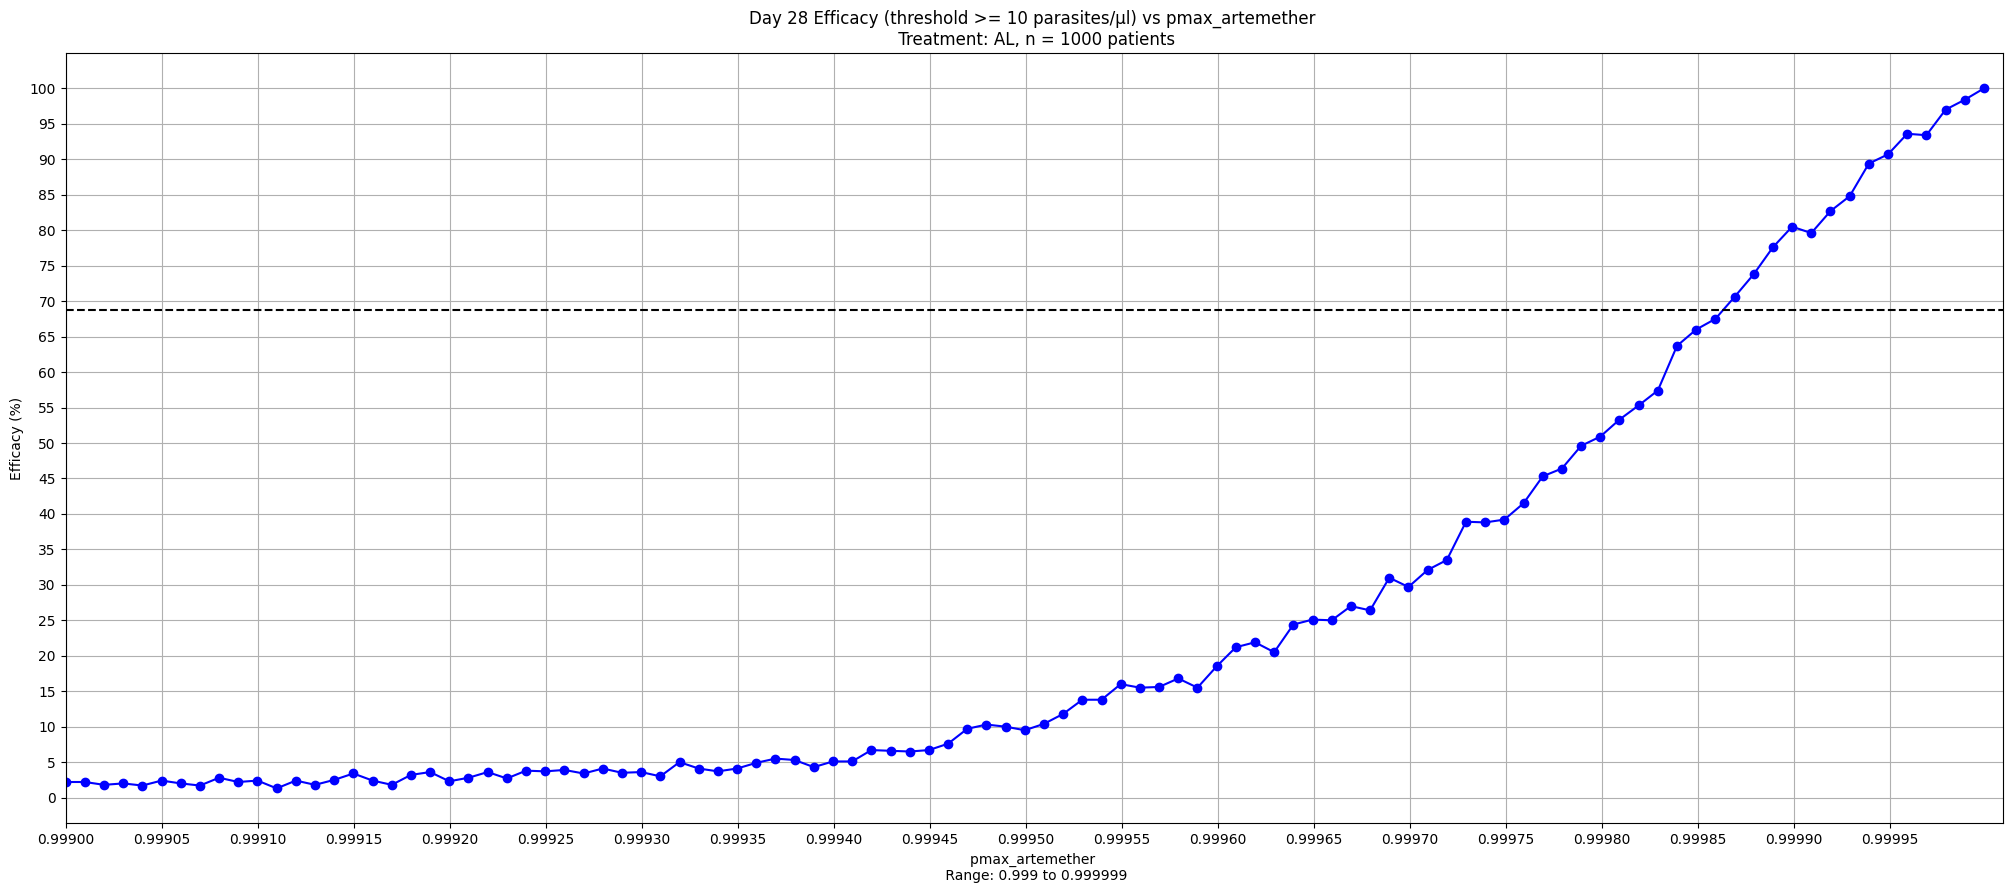

In [74]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, efficacy_values, marker='o', linestyle='-', color='b')
plt.xlabel(f'pmax_artemether \n Range: {min(pmax_values)} to {max(pmax_values)}')
plt.ylabel('Efficacy (%)')
plt.title(f"Day 28 Efficacy (threshold >= 10 parasites/μl) vs pmax_artemether \n Treatment: AL, n = {n_patients} patients")
plt.grid(True)
plt.xlim(min(pmax_values), max(pmax_values)+0.00001)  # Set x-axis limits
plt.xticks(np.arange(min(pmax_values), max(pmax_values),0.00005))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=68.8, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig(f"pkpd_AL_{file_suffix}.png")  # Save the plot as a PNG file
plt.show()

In [76]:
# Define the range for pmax_artemether
min_pmax = 0.9995
max_pmax = 0.99999999

# Define weight_art values
pmax_values = np.linspace(min_pmax, max_pmax, 101) 

# Initialize a grid to store the clearance rates
efficacy_values = np.zeros(len(pmax_values))
failed_treatment_count_values = np.zeros(len(pmax_values))

print(pmax_values)

[0.9995     0.999505   0.99951    0.999515   0.99952    0.999525
 0.99953    0.999535   0.99954    0.999545   0.99955    0.999555
 0.99956    0.999565   0.99957    0.999575   0.99958    0.999585
 0.99959    0.999595   0.9996     0.999605   0.99961    0.999615
 0.99962    0.999625   0.99963    0.999635   0.99964    0.999645
 0.99965    0.999655   0.99966    0.999665   0.99967    0.999675
 0.99968    0.999685   0.99969    0.999695   0.9997     0.999705
 0.99971    0.999715   0.99972    0.999725   0.99973    0.999735
 0.99974    0.999745   0.99974999 0.99975499 0.99975999 0.99976499
 0.99976999 0.99977499 0.99977999 0.99978499 0.99978999 0.99979499
 0.99979999 0.99980499 0.99980999 0.99981499 0.99981999 0.99982499
 0.99982999 0.99983499 0.99983999 0.99984499 0.99984999 0.99985499
 0.99985999 0.99986499 0.99986999 0.99987499 0.99987999 0.99988499
 0.99988999 0.99989499 0.99989999 0.99990499 0.99990999 0.99991499
 0.99991999 0.99992499 0.99992999 0.99993499 0.99993999 0.99994499
 0.99994999

In [77]:
def run_simulation_pmax_artemether_adj(idx, pmax_artemether, n_patients):
    command_pmax_artemether = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", str(n_patients),
        "--weight", "54",
        "--pmax_artemether", str(pmax_artemether),
        "--pmax_lum", "0",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_pmax_artemether = subprocess.run(command_pmax_artemether, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmax_artemether = output_pmax_artemether.stdout.splitlines()
        df_pmax_artemether = pd.DataFrame(
            [line.split() for line in lines_pmax_artemether],
            columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_pmax_artemether = df_pmax_artemether.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_pmax_artemether[df_pmax_artemether['PARASITEDENSITY'] >= 10].shape[0]
        total_patients = df_pmax_artemether['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_pmax_artemether)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for pmax_artemether: {pmax_artemether}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

    except Exception as e:
        print(f"An unexpected error occurred for pmax_artemether: {pmax_artemether}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

In [81]:

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

n_patients = 10000  # Number of patients for each simulation
file_suffix = "artemether_monotherapy_calibration_07"

# Prepare a list of parameters to pass to the pool
params_list = [(i, pmax_values[i], n_patients) for i in range(len(pmax_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation_pmax_artemether_adj, params_list):
            idx, efficacy, df_pmax_artemether = result
            results.append((idx, efficacy, df_pmax_artemether))
            if df_pmax_artemether is not None:
                dfs.append(df_pmax_artemether)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy, df_pmax_artemether in results:
    efficacy_values[idx] = efficacy

# Create a DataFrame with pmax_artemether_values and clearance_rates
df = pd.DataFrame({
    'pmax_artemether': pmax_values,
    'Efficacy': efficacy_values
})

# Save the DataFrame to a pickle file
df.to_pickle(f"pkpd_AL_{file_suffix}.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle(f"pkpd_AL_{file_suffix}.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv(f"pkpd_AL_{file_suffix}.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 101/101 [50:42<00:00, 30.13s/it]   

DataFrame saved as pickle and CSV files successfully.


In [93]:
df

,pmax_artemether,Efficacy
0,0.999500,10.45
1,0.999505,10.84
2,0.999510,11.20
3,0.999515,11.96
4,0.999520,12.58
...,...,...
96,0.999980,96.85
97,0.999985,98.31
98,0.999990,99.10
99,0.999995,99.68


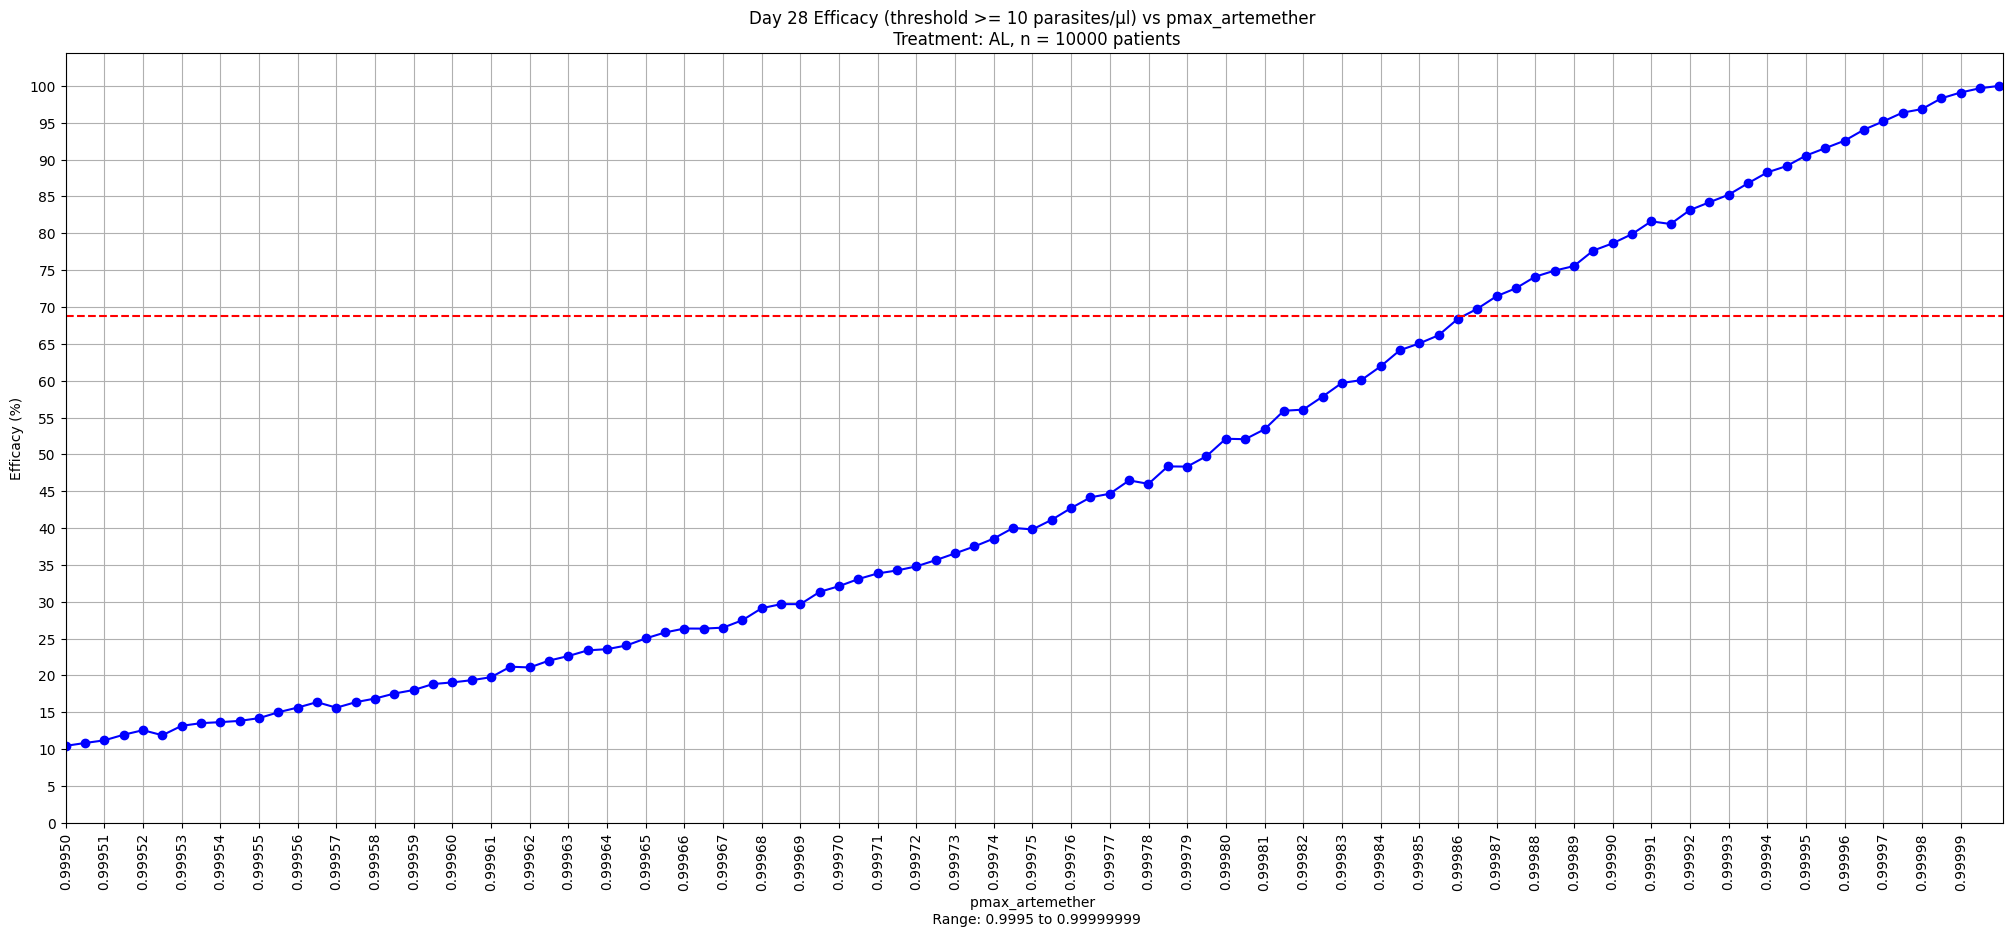

In [94]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, efficacy_values, marker='o', linestyle='-', color='b')
plt.xlabel(f'pmax_artemether \n Range: {min(pmax_values)} to {max(pmax_values)}')
plt.ylabel('Efficacy (%)')
plt.title(f"Day 28 Efficacy (threshold >= 10 parasites/μl) vs pmax_artemether \n Treatment: AL, n = {n_patients} patients")
plt.grid(True)
plt.xlim(min(pmax_values), max(pmax_values)+0.000001)  # Set x-axis limits
plt.xticks(np.arange(min(pmax_values), max(pmax_values),0.00001), rotation = 90)  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=68.8, color='r', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig(f"pkpd_AL_{file_suffix}.png")  # Save the plot as a PNG file
plt.show()

In [32]:
# Define the range for pmax_artemether
min_pmax = 0.999
max_pmax = 0.999999

# Define weight_art values
pmax_values = np.linspace(min_pmax, max_pmax, 25) 

# Initialize a grid to store the clearance rates
efficacy_values = np.zeros(len(pmax_values))
failed_treatment_count_values = np.zeros(len(pmax_values))

print(pmax_values)

[0.999      0.99904163 0.99908325 0.99912488 0.9991665  0.99920813
 0.99924975 0.99929137 0.999333   0.99937462 0.99941625 0.99945787
 0.9994995  0.99954113 0.99958275 0.99962438 0.999666   0.99970762
 0.99974925 0.99979087 0.9998325  0.99987412 0.99991575 0.99995737
 0.999999  ]


In [33]:
def run_simulation_pmax_artemether_adj(idx, pmax_artemether, n_patients):
    command_pmax_artemether = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", str(n_patients),
        "--weight", "40",
        "--pmax_artemether", str(pmax_artemether),
        "--pmax_lum", "0",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_pmax_artemether = subprocess.run(command_pmax_artemether, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmax_artemether = output_pmax_artemether.stdout.splitlines()
        df_pmax_artemether = pd.DataFrame(
            [line.split() for line in lines_pmax_artemether],
            columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_pmax_artemether = df_pmax_artemether.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_pmax_artemether[df_pmax_artemether['PARASITEDENSITY'] >= 10].shape[0]
        total_patients = df_pmax_artemether['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_pmax_artemether)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for pmax_artemether: {pmax_artemether}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

    except Exception as e:
        print(f"An unexpected error occurred for pmax_artemether: {pmax_artemether}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

In [18]:

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

n_patients = 500  # Number of patients for each simulation
file_suffix = "artemether_monotherapy_calibration_07"

# Prepare a list of parameters to pass to the pool
params_list = [(i, pmax_values[i], n_patients) for i in range(len(pmax_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation_pmax_artemether_adj, params_list):
            idx, efficacy, df_pmax_artemether = result
            results.append((idx, efficacy, df_pmax_artemether))
            if df_pmax_artemether is not None:
                dfs.append(df_pmax_artemether)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy, df_pmax_artemether in results:
    efficacy_values[idx] = efficacy

# Create a DataFrame with pmax_artemether_values and clearance_rates
df = pd.DataFrame({
    'pmax_artemether': pmax_values,
    'Efficacy': efficacy_values
})

# Save the DataFrame to a pickle file
df.to_pickle(f"pkpd_AL_{file_suffix}.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle(f"pkpd_AL_{file_suffix}.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv(f"pkpd_AL_{file_suffix}.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 25/25 [00:44<00:00,  1.79s/it]

DataFrame saved as pickle and CSV files successfully.


In [25]:
df

,pmax_artemether,Efficacy
0,0.999900,63.6
1,0.999904,64.2
2,0.999908,65.8
3,0.999912,66.4
4,0.999916,63.4
5,0.999921,65.6
6,0.999925,72.4
7,0.999929,70.4
8,0.999933,70.6
9,0.999937,76.2


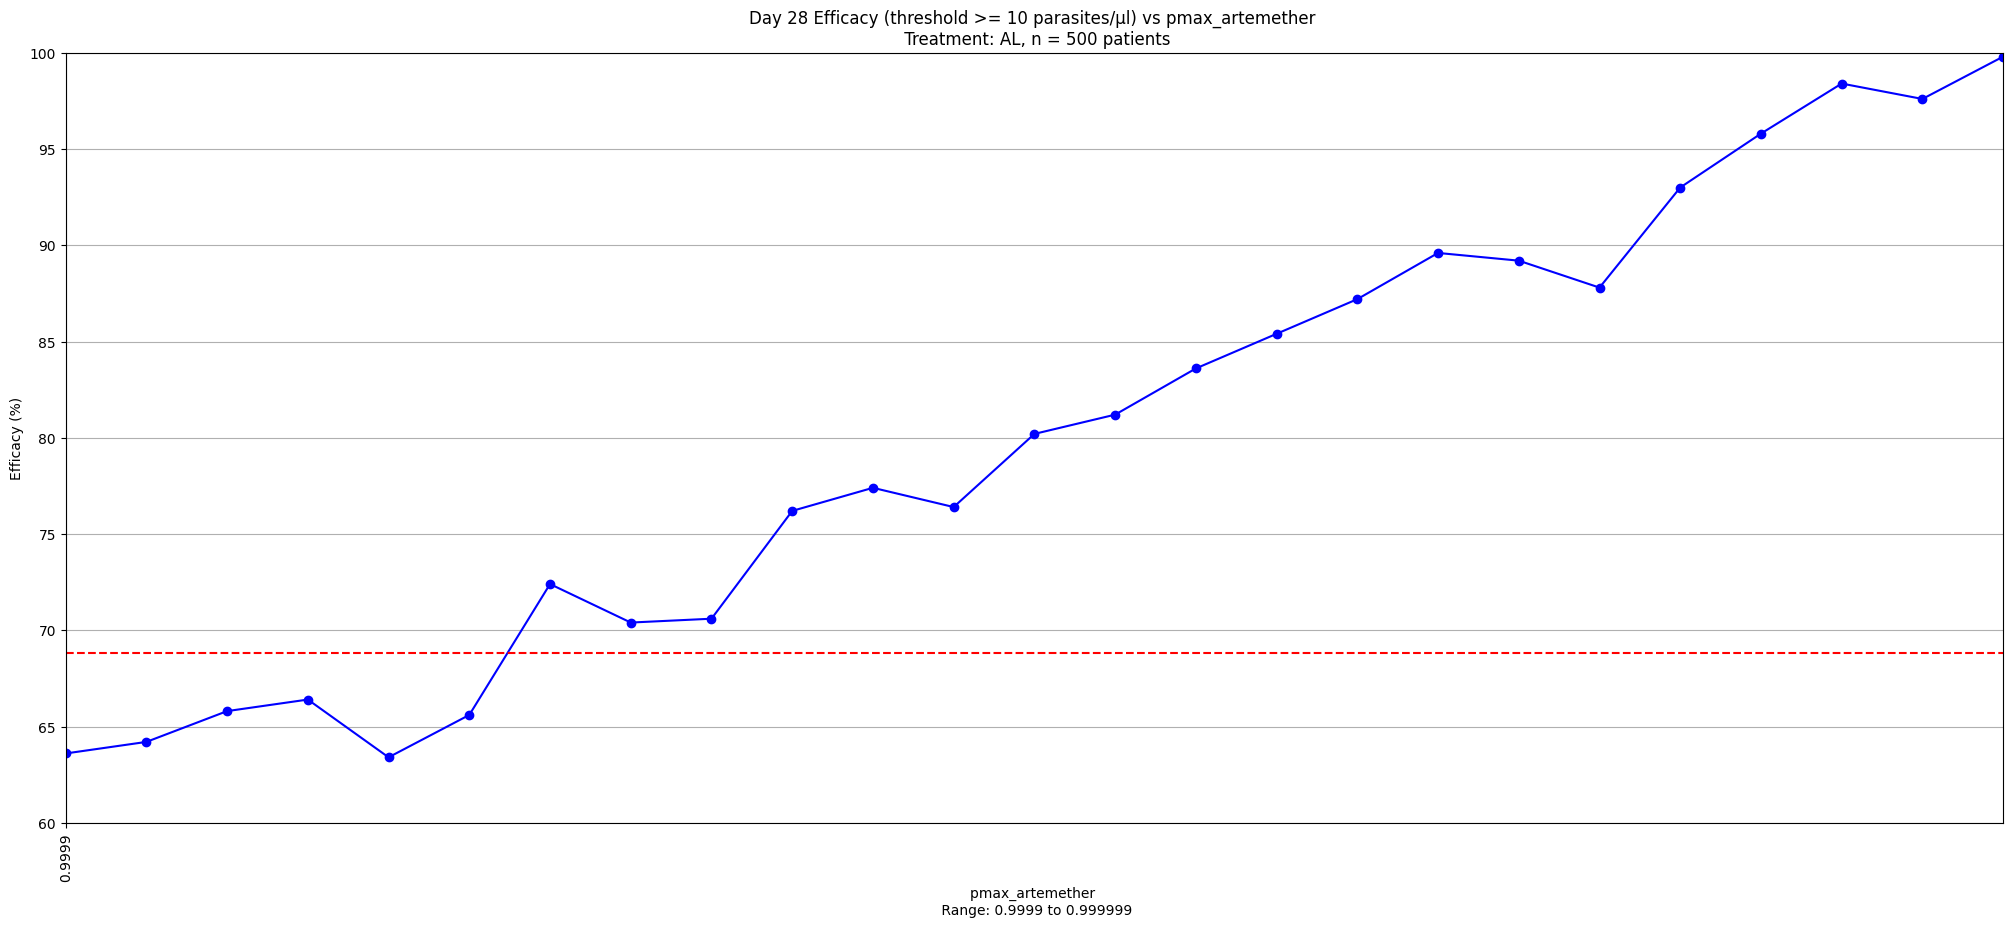

In [23]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, efficacy_values, marker='o', linestyle='-', color='b')
plt.xlabel(f'pmax_artemether \n Range: {min(pmax_values)} to {max(pmax_values)}')
plt.ylabel('Efficacy (%)')
plt.title(f"Day 28 Efficacy (threshold >= 10 parasites/μl) vs pmax_artemether \n Treatment: AL, n = {n_patients} patients")
plt.grid(True)
plt.xlim(min(pmax_values), max(pmax_values))  # Set x-axis limits
plt.xticks(np.arange(min(pmax_values), max(pmax_values)), rotation = 90)  # Adjust tick marks if necessary
plt.ylim(60, 100)  # Set y-axis limits from 90% to 100%
plt.yticks(np.arange(60, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=68.8, color='r', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig(f"pkpd_AL_{file_suffix}.png")  # Save the plot as a PNG file
plt.show()

In [26]:
# Define the range for pmax_artemether
min_pmax = 0.99997
max_pmax = 0.999999

# Define weight_art values
pmax_values = np.linspace(min_pmax, max_pmax, 25) 

# Initialize a grid to store the clearance rates
efficacy_values = np.zeros(len(pmax_values))
failed_treatment_count_values = np.zeros(len(pmax_values))

print(pmax_values)

[0.99997    0.99997121 0.99997242 0.99997362 0.99997483 0.99997604
 0.99997725 0.99997846 0.99997967 0.99998087 0.99998208 0.99998329
 0.9999845  0.99998571 0.99998692 0.99998813 0.99998933 0.99999054
 0.99999175 0.99999296 0.99999417 0.99999538 0.99999658 0.99999779
 0.999999  ]


In [27]:
def run_simulation_pmax_artemether_adj(idx, pmax_artemether, n_patients):
    command_pmax_artemether = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", str(n_patients),
        "--weight", "30",
        "--pmax_artemether", str(pmax_artemether),
        "--pmax_lum", "0",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_pmax_artemether = subprocess.run(command_pmax_artemether, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmax_artemether = output_pmax_artemether.stdout.splitlines()
        df_pmax_artemether = pd.DataFrame(
            [line.split() for line in lines_pmax_artemether],
            columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_pmax_artemether = df_pmax_artemether.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_pmax_artemether[df_pmax_artemether['PARASITEDENSITY'] >= 10].shape[0]
        total_patients = df_pmax_artemether['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_pmax_artemether)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for pmax_artemether: {pmax_artemether}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

    except Exception as e:
        print(f"An unexpected error occurred for pmax_artemether: {pmax_artemether}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

In [28]:

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

n_patients = 500  # Number of patients for each simulation
file_suffix = "artemether_monotherapy_calibration_07"

# Prepare a list of parameters to pass to the pool
params_list = [(i, pmax_values[i], n_patients) for i in range(len(pmax_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation_pmax_artemether_adj, params_list):
            idx, efficacy, df_pmax_artemether = result
            results.append((idx, efficacy, df_pmax_artemether))
            if df_pmax_artemether is not None:
                dfs.append(df_pmax_artemether)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy, df_pmax_artemether in results:
    efficacy_values[idx] = efficacy

# Create a DataFrame with pmax_artemether_values and clearance_rates
df = pd.DataFrame({
    'pmax_artemether': pmax_values,
    'Efficacy': efficacy_values
})

# Save the DataFrame to a pickle file
df.to_pickle(f"pkpd_AL_{file_suffix}.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle(f"pkpd_AL_{file_suffix}.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv(f"pkpd_AL_{file_suffix}.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 25/25 [00:47<00:00,  1.91s/it]

DataFrame saved as pickle and CSV files successfully.


In [31]:
df

,pmax_artemether,Efficacy
0,0.999970,66.4
1,0.999971,68.2
2,0.999972,67.8
3,0.999974,71.0
4,0.999975,69.2
5,0.999976,66.8
6,0.999977,70.6
7,0.999978,72.6
8,0.999980,73.6
9,0.999981,76.0


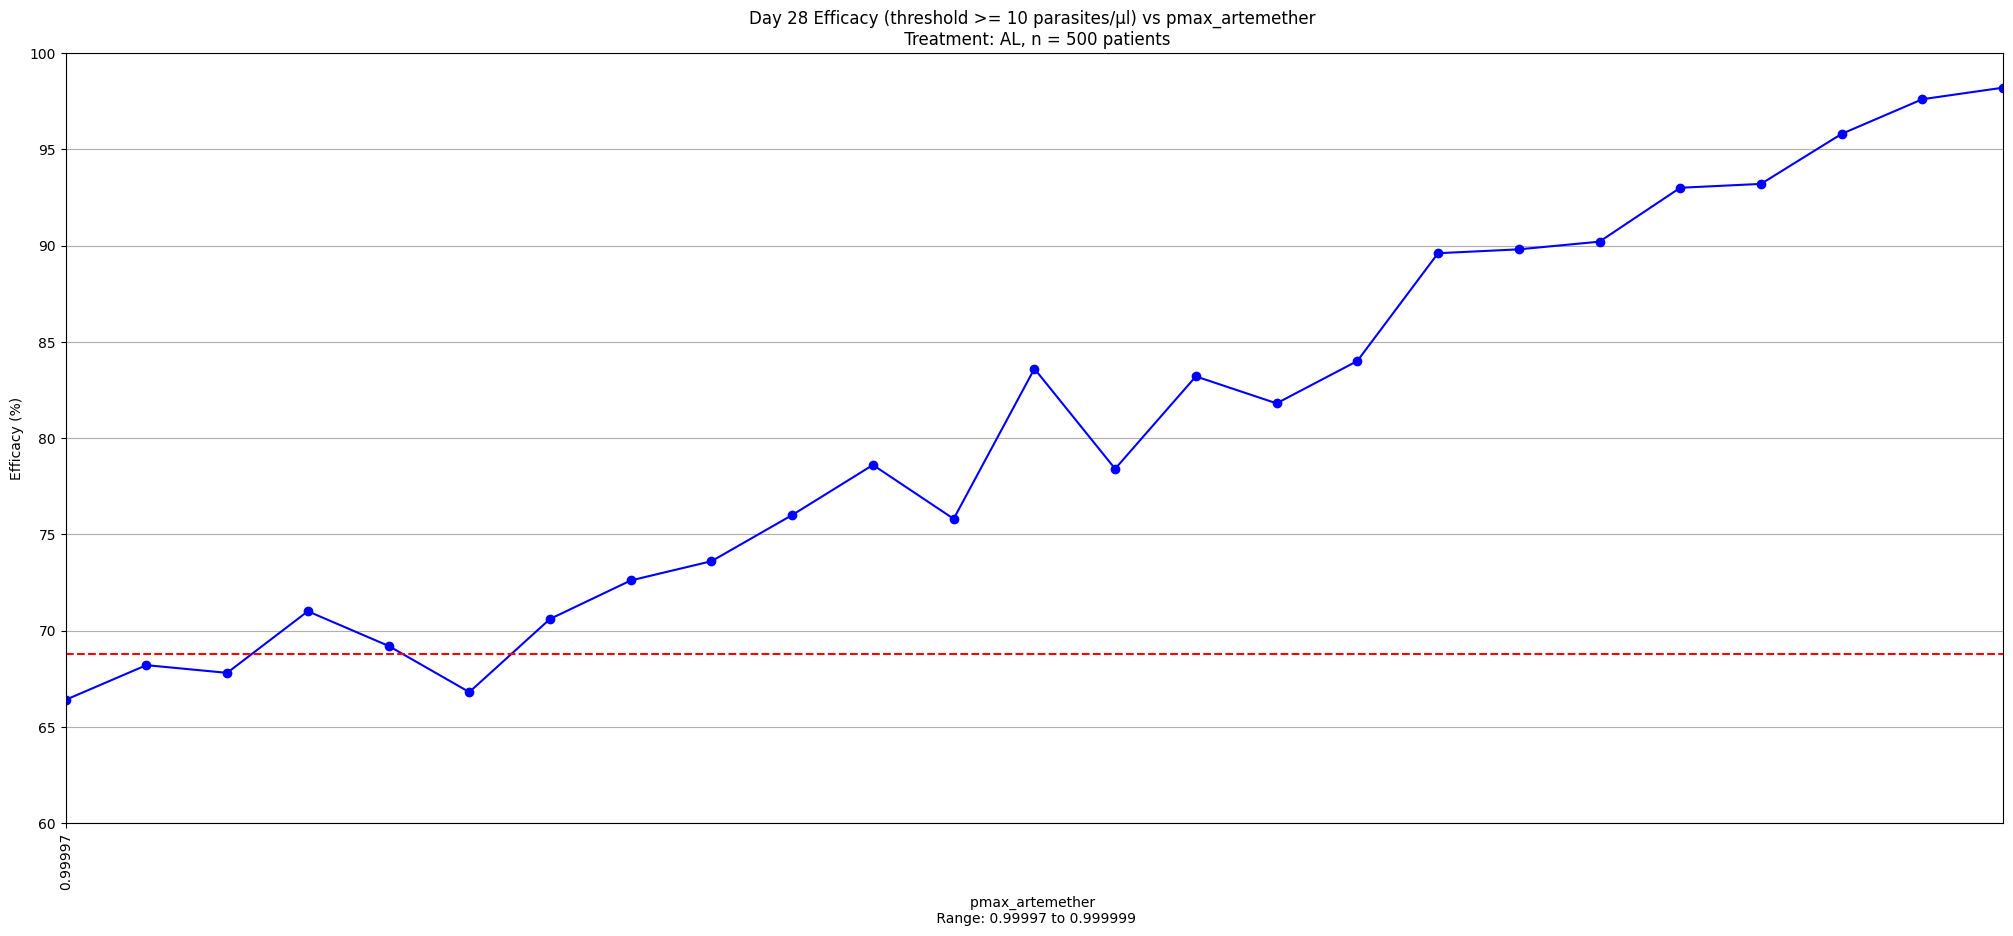

In [30]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, efficacy_values, marker='o', linestyle='-', color='b')
plt.xlabel(f'pmax_artemether \n Range: {min(pmax_values)} to {max(pmax_values)}')
plt.ylabel('Efficacy (%)')
plt.title(f"Day 28 Efficacy (threshold >= 10 parasites/μl) vs pmax_artemether \n Treatment: AL, n = {n_patients} patients")
plt.grid(True)
plt.xlim(min(pmax_values), max(pmax_values))  # Set x-axis limits
plt.xticks(np.arange(min(pmax_values), max(pmax_values)), rotation = 90)  # Adjust tick marks if necessary
plt.ylim(60, 100)  # Set y-axis limits from 90% to 100%
plt.yticks(np.arange(60, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=68.8, color='r', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig(f"pkpd_AL_{file_suffix}.png")  # Save the plot as a PNG file
plt.show()

<BR>

# `ec50_artemether` vs `pmax_artemether` heatmap for artemether monotherapy, weight = 54 Kg
### Coz a pmax_artemether of 0.99986 may be a bit too high

<br>

### Experiment Number: 01

In [233]:
# Setting min and max values for EC50_artemether and pmax_artemether
min_ec50 = 0.1 #exp(0.525 * log(2700)); // use natural log, 63.30907617
max_ec50 = 1

min_pmax = 0.9
max_pmax = 0.9995

# Define the range for EC50 and pmax
ec50_values = np.linspace(min_ec50, max_ec50, 25)
pmax_values = np.linspace(min_pmax, max_pmax, 25)

#Saving EC50_artemether and pmax_artemether range for future reference
folder = "artemether_monotherapy_calibration_heatmap_results"
os.makedirs(folder, exist_ok=True) 

np.savetxt(f'{folder}/artemether_monotherapy_calibration_heatmap_pmax_range_01.txt', pmax_values, delimiter=',', fmt='%5f')
np.savetxt(f'{folder}/artemether_monotherapy_calibratione_heatmap_ec50_range_01.txt', ec50_values, delimiter=',', fmt='%5f')

# Create a meshgrid for all combinations
ec50_grid, pmax_grid = np.meshgrid(ec50_values, pmax_values)
trial_efficacy = np.zeros(ec50_grid.shape)

# Flatten the grids for parallel processing
ec50_flat = ec50_grid.flatten()
pmax_flat = pmax_grid.flatten()

#Checking pmax_artemether, ec50_artemether by eye
print("pmax_artemether Range: ",pmax_values)
print("EC50_artemether Range: ",ec50_values)

pmax_artemether Range:  [0.9        0.90414583 0.90829167 0.9124375  0.91658333 0.92072917
 0.924875   0.92902083 0.93316667 0.9373125  0.94145833 0.94560417
 0.94975    0.95389583 0.95804167 0.9621875  0.96633333 0.97047917
 0.974625   0.97877083 0.98291667 0.9870625  0.99120833 0.99535417
 0.9995    ]
EC50_artemether Range:  [0.1    0.1375 0.175  0.2125 0.25   0.2875 0.325  0.3625 0.4    0.4375
 0.475  0.5125 0.55   0.5875 0.625  0.6625 0.7    0.7375 0.775  0.8125
 0.85   0.8875 0.925  0.9625 1.    ]


In [234]:
# Function to run a single simulation for a given weight value
start_time = time.monotonic()

# Function to run a single simulation for a given (ec50, pmax) pair
def run_simulation(params):
    i, j, ec50, pmax = params

    command_ec50_pmax_art = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "500",
        "--pmax_lum", "0",
        "--pmax_artemether", str(pmax),
        "--ec50_artemether", str(ec50),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_ec50_pmax_art = subprocess.run(command_ec50_pmax_art, capture_output=True, text=True, check=True)

        # Process the output
        lines_ec50_pmax_art = output_ec50_pmax_art.stdout.splitlines()
        df_ec50_pmax_art = pd.DataFrame(
            [line.split() for line in lines_ec50_pmax_art],
            columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_ec50_pmax_art = df_ec50_pmax_art.iloc[1:].apply(pd.to_numeric, errors='coerce')

        folder = "artemether_monotherapy_calibration_heatmap_results"
        os.makedirs(folder, exist_ok=True)  # Creates folder if it doesn't exist

        # Saving the Dataframe as a CSV file 
        filepath = f"{folder}/artemether_monotherapy_calibration_heatmap_pmax_{pmax:.2f}_ec50_{ec50:.2f}.csv"
        df_ec50_pmax_art.to_csv(filepath, index=False)

        # Calculate the efficacy
        # Here the hour filter is just to make sure the data is as expected

        failed_treatment_count = df_ec50_pmax_art[(df_ec50_pmax_art['PARASITEDENSITY'] >= 10) & (df_ec50_pmax_art['HOUR'] == 671.0)].shape[0]
        total_patients = df_ec50_pmax_art['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        # Output the failed treatment count for each pmax-EC50 pair as a text file
        # Naming the text file with the pmax-EC50 pair

        filepath = f"{folder}/artemether_monotherapy_calibration_heatmap_pmax_{pmax:.2f}_ec50_{ec50:.2f}.txt"

        with open(filepath, "w") as f:
            f.write(f"pmax_lum: {pmax}, EC50_lum: {ec50}, Failed treatment count: {failed_treatment_count}\n")

        return (i, j, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for EC50: {ec50}, pmax: {pmax}: {e}")
        return (i, j, np.nan)  # Return NaN in case of failure

In [ ]:
# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, j, ec50_flat[i * len(pmax_values) + j], pmax_flat[i * len(pmax_values) + j])
               for i in range(len(ec50_values)) for j in range(len(pmax_values))]

# Run simulations in parallel
with Pool(processes=num_workers) as pool:
    # Use tqdm to track the progress of the parallel tasks
    results = list(tqdm(pool.imap(run_simulation, params_list), total=len(params_list)))

# Update the efficacy grid with the results
for i, j, efficacy in results:
    trial_efficacy[i, j] = efficacy

# Create a DataFrame from the efficacy grid
df_trial_efficacy = pd.DataFrame(trial_efficacy, index=pmax_values, columns=ec50_values)

# Save the DataFrame to a CSV file
df_trial_efficacy.to_csv(f"{folder}/artemether_monotherapy_calibration_heatmap.csv")

# Save the DataFrame to a pickle file
df_trial_efficacy.to_pickle(f"{folder}/artemether_monotherapy_calibration_heatmap.pyobj")

print("Parallel simulation completed and results saved in CSV and pickle formats.")

end_time = time.monotonic()
today = datetime.date.today()
print("\nToday's date: ", today, "\n")
print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")


100%|██████████| 625/625 [16:32<00:00,  1.59s/it] 

Parallel simulation completed and results saved in CSV and pickle formats.

Today's date:  2025-06-04 

Length of simulation:  0:16:36.052533 



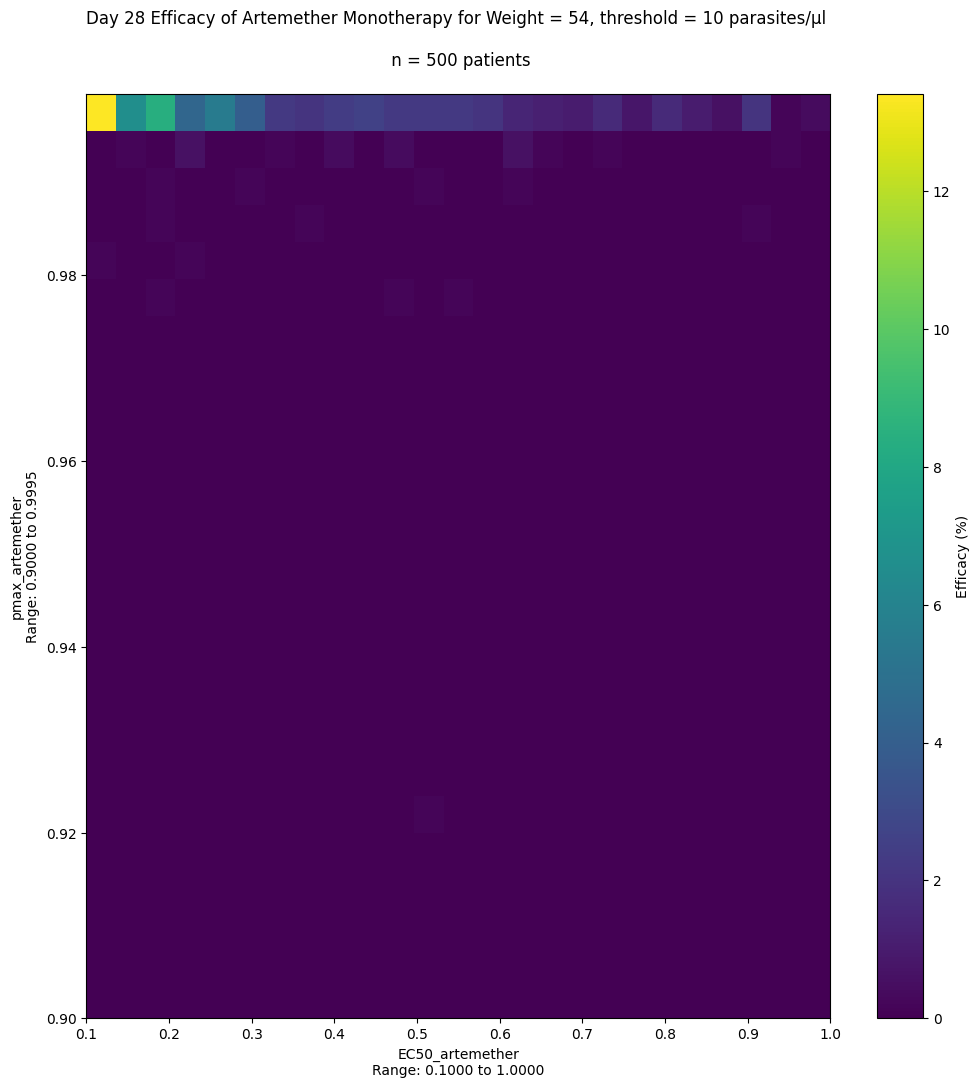

In [238]:

plt.figure(figsize=(12, 12))

plt.imshow(df_trial_efficacy, extent=(min_ec50, max_ec50, min_pmax, max_pmax), origin='lower', cmap='viridis', aspect = 'auto')

# Create the colorbar
plt.colorbar(label='Efficacy (%)')

# Set the labels and title
plt.xlabel('EC50_artemether\nRange: {:.4f} to {:.4f}'.format(min_ec50, max_ec50))
plt.ylabel('pmax_artemether\nRange: {:.4f} to {:.4f}'.format(min_pmax, max_pmax))
plt.title('Day 28 Efficacy of Artemether Monotherapy for Weight = 54, threshold = 10 parasites/μl \n\n n = 500 patients\n')

#Save plot
plt.savefig(f"{folder}/artemether_monotherapy_calibration_heatmap_01.png")
# Show the plot
plt.show()

<br>

### Experiment Number: 2

In [240]:
# Setting min and max values for EC50_artemether and pmax_artemether
min_ec50 = 0.01 #exp(0.525 * log(2700)); // use natural log, 63.30907617
max_ec50 = 0.1

min_pmax = 0.9995
max_pmax = 0.999999

# Define the range for EC50 and pmax
ec50_values = np.linspace(min_ec50, max_ec50, 100)
pmax_values = np.linspace(min_pmax, max_pmax, 100)

#Saving EC50_artemether and pmax_artemether range for future reference
experiment = "02"
folder = f"artemether_monotherapy_calibration_heatmap_results_{experiment}"
os.makedirs(folder, exist_ok=True) 

np.savetxt(f'{folder}/artemether_monotherapy_calibration_heatmap_pmax_range_{experiment}.txt', pmax_values, delimiter=',', fmt='%5f')
np.savetxt(f'{folder}/artemether_monotherapy_calibratione_heatmap_ec50_range_{experiment}.txt', ec50_values, delimiter=',', fmt='%5f')

# Create a meshgrid for all combinations
ec50_grid, pmax_grid = np.meshgrid(ec50_values, pmax_values)
trial_efficacy = np.zeros(ec50_grid.shape)

# Flatten the grids for parallel processing
ec50_flat = ec50_grid.flatten()
pmax_flat = pmax_grid.flatten()

#Checking pmax_artemether, ec50_artemether by eye
print("pmax_artemether Range: ",pmax_values)
print("EC50_artemether Range: ",ec50_values)

pmax_artemether Range:  [0.9995     0.99950504 0.99951008 0.99951512 0.99952016 0.9995252
 0.99953024 0.99953528 0.99954032 0.99954536 0.9995504  0.99955544
 0.99956048 0.99956553 0.99957057 0.99957561 0.99958065 0.99958569
 0.99959073 0.99959577 0.99960081 0.99960585 0.99961089 0.99961593
 0.99962097 0.99962601 0.99963105 0.99963609 0.99964113 0.99964617
 0.99965121 0.99965625 0.99966129 0.99966633 0.99967137 0.99967641
 0.99968145 0.99968649 0.99969154 0.99969658 0.99970162 0.99970666
 0.9997117  0.99971674 0.99972178 0.99972682 0.99973186 0.9997369
 0.99974194 0.99974698 0.99975202 0.99975706 0.9997621  0.99976714
 0.99977218 0.99977722 0.99978226 0.9997873  0.99979234 0.99979738
 0.99980242 0.99980746 0.99981251 0.99981755 0.99982259 0.99982763
 0.99983267 0.99983771 0.99984275 0.99984779 0.99985283 0.99985787
 0.99986291 0.99986795 0.99987299 0.99987803 0.99988307 0.99988811
 0.99989315 0.99989819 0.99990323 0.99990827 0.99991331 0.99991835
 0.99992339 0.99992843 0.99993347 0.9999

In [241]:
# Function to run a single simulation for a given weight value
start_time = time.monotonic()

# Function to run a single simulation for a given (ec50, pmax) pair
def run_simulation(params):
    i, j, ec50, pmax = params

    command_ec50_pmax_art = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "500",
        "--pmax_lum", "0",
        "--pmax_artemether", str(pmax),
        "--ec50_artemether", str(ec50),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_ec50_pmax_art = subprocess.run(command_ec50_pmax_art, capture_output=True, text=True, check=True)

        # Process the output
        lines_ec50_pmax_art = output_ec50_pmax_art.stdout.splitlines()
        df_ec50_pmax_art = pd.DataFrame(
            [line.split() for line in lines_ec50_pmax_art],
            columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_ec50_pmax_art = df_ec50_pmax_art.iloc[1:].apply(pd.to_numeric, errors='coerce')

        experiment = "02"
        folder = f"artemether_monotherapy_calibration_heatmap_results_{experiment}"
        os.makedirs(folder, exist_ok=True)  # Creates folder if it doesn't exist

        # Saving the Dataframe as a CSV file 
        filepath = f"{folder}/artemether_monotherapy_calibration_heatmap_pmax_{pmax:.2f}_ec50_{ec50:.2f}.csv"
        df_ec50_pmax_art.to_csv(filepath, index=False)

        # Calculate the efficacy
        # Here the hour filter is just to make sure the data is as expected

        failed_treatment_count = df_ec50_pmax_art[(df_ec50_pmax_art['PARASITEDENSITY'] >= 10) & (df_ec50_pmax_art['HOUR'] == 671.0)].shape[0]
        total_patients = df_ec50_pmax_art['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        # Output the failed treatment count for each pmax-EC50 pair as a text file
        # Naming the text file with the pmax-EC50 pair

        filepath = f"{folder}/artemether_monotherapy_calibration_heatmap_pmax_{pmax:.2f}_ec50_{ec50:.2f}.txt"

        with open(filepath, "w") as f:
            f.write(f"pmax_lum: {pmax}, EC50_lum: {ec50}, Failed treatment count: {failed_treatment_count}\n")

        return (i, j, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for EC50: {ec50}, pmax: {pmax}: {e}")
        return (i, j, np.nan)  # Return NaN in case of failure

In [242]:
# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, j, ec50_flat[i * len(pmax_values) + j], pmax_flat[i * len(pmax_values) + j])
               for i in range(len(ec50_values)) for j in range(len(pmax_values))]

# Run simulations in parallel
with Pool(processes=num_workers) as pool:
    # Use tqdm to track the progress of the parallel tasks
    results = list(tqdm(pool.imap(run_simulation, params_list), total=len(params_list)))

# Update the efficacy grid with the results
for i, j, efficacy in results:
    trial_efficacy[i, j] = efficacy

# Create a DataFrame from the efficacy grid
df_trial_efficacy = pd.DataFrame(trial_efficacy, index=pmax_values, columns=ec50_values)


experiment = "02"
folder = f"artemether_monotherapy_calibration_heatmap_results_{experiment}"
# Save the DataFrame to a CSV file
df_trial_efficacy.to_csv(f"{folder}/artemether_monotherapy_calibration_heatmap_{experiment}.csv")

# Save the DataFrame to a pickle file
df_trial_efficacy.to_pickle(f"{folder}/artemether_monotherapy_calibration_heatmap_{experiment}.pyobj")
.
print("Parallel simulation completed and results saved in CSV and pickle formats.")

end_time = time.monotonic()
today = datetime.date.today()
print("\nToday's date: ", today, "\n")
print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")


100%|██████████| 10000/10000 [4:04:46<00:00,  1.47s/it] 

Parallel simulation completed and results saved in CSV and pickle formats.

Today's date:  2025-06-04 

Length of simulation:  4:08:24.681337 



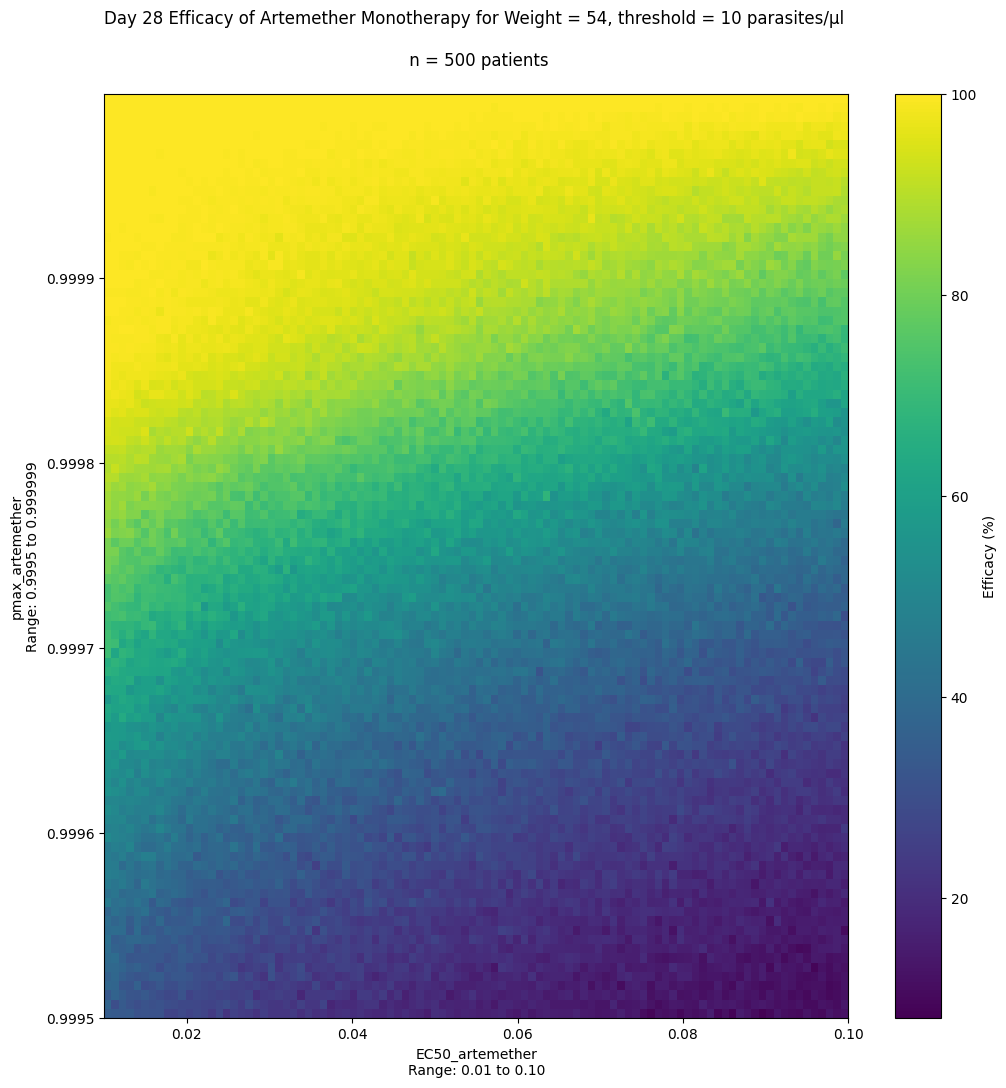

In [250]:

plt.figure(figsize=(12, 12))

plt.imshow(df_trial_efficacy, extent=(min_ec50, max_ec50, min_pmax, max_pmax), origin='lower', cmap='viridis', aspect = 'auto')

# Create the colorbar
plt.colorbar(label='Efficacy (%)')

# Set the labels and title
plt.xlabel('EC50_artemether\nRange: {:.2f} to {:.2f}'.format(min_ec50, max_ec50))
plt.ylabel('pmax_artemether\nRange: {:.4f} to {:.6f}'.format(min_pmax, max_pmax))
plt.title('Day 28 Efficacy of Artemether Monotherapy for Weight = 54, threshold = 10 parasites/μl \n\n n = 500 patients\n')

experiment = "02"
folder = f"artemether_monotherapy_calibration_heatmap_results_{experiment}"
#Save plot
plt.savefig(f"{folder}/artemether_monotherapy_calibration_heatmap_{experiment}.png")
# Show the plot
plt.show()

In [253]:
for i in range(len(ec50_values)):
    for j in range(len(pmax_values)):
        print(f"EC50: {ec50_values[i]:.2f}, pmax: {pmax_values[j]:.6f}, Efficacy: {df_trial_efficacy.iloc[i, j]:.2f}%")
    #Save in one text file
        with open(f"{folder}/artemether_monotherapy_calibration_heatmap_{experiment}_results.txt", "a") as f:
            f.write(f"EC50: {ec50_values[i]:.2f}, pmax: {pmax_values[j]:.6f}, Efficacy: {df_trial_efficacy.iloc[i, j]:.2f}%\n")
    # Save in one dataframe and then save as csv
df_results = pd.DataFrame({
    'EC50_artemether': np.repeat(ec50_values, len(pmax_values)),
    'pmax_artemether': np.tile(pmax_values, len(ec50_values)),
    'Efficacy': df_trial_efficacy.values.flatten()
})
df_results.to_csv(f"{folder}/artemether_monotherapy_calibration_heatmap_{experiment}_results.csv", index=False)

EC50: 0.01, pmax: 0.999500, Efficacy: 34.80%
EC50: 0.01, pmax: 0.999505, Efficacy: 34.00%
EC50: 0.01, pmax: 0.999510, Efficacy: 33.60%
EC50: 0.01, pmax: 0.999515, Efficacy: 34.00%
EC50: 0.01, pmax: 0.999520, Efficacy: 31.20%
EC50: 0.01, pmax: 0.999525, Efficacy: 31.60%
EC50: 0.01, pmax: 0.999530, Efficacy: 31.00%
EC50: 0.01, pmax: 0.999535, Efficacy: 31.00%
EC50: 0.01, pmax: 0.999540, Efficacy: 26.80%
EC50: 0.01, pmax: 0.999545, Efficacy: 26.40%
EC50: 0.01, pmax: 0.999550, Efficacy: 28.40%
EC50: 0.01, pmax: 0.999555, Efficacy: 26.40%
EC50: 0.01, pmax: 0.999560, Efficacy: 27.80%
EC50: 0.01, pmax: 0.999566, Efficacy: 27.00%
EC50: 0.01, pmax: 0.999571, Efficacy: 24.00%
EC50: 0.01, pmax: 0.999576, Efficacy: 27.60%
EC50: 0.01, pmax: 0.999581, Efficacy: 21.80%
EC50: 0.01, pmax: 0.999586, Efficacy: 25.80%
EC50: 0.01, pmax: 0.999591, Efficacy: 24.40%
EC50: 0.01, pmax: 0.999596, Efficacy: 23.80%
EC50: 0.01, pmax: 0.999601, Efficacy: 21.60%
EC50: 0.01, pmax: 0.999606, Efficacy: 25.00%
EC50: 0.01

In [269]:
filtered_results = df_results[(df_results['Efficacy'] >= 68.0) & (df_results['Efficacy'] <= 69.0)]
filtered_results

,EC50_artemether,pmax_artemether,Efficacy
3801,0.044545,0.999505,68.0
3902,0.045455,0.999510,68.2
4101,0.047273,0.999505,68.8
4103,0.047273,0.999515,68.8
4106,0.047273,0.999530,68.0
...,...,...,...
7197,0.074545,0.999989,68.2
7199,0.074545,0.999999,69.0
7294,0.075455,0.999974,68.2
7298,0.075455,0.999994,68.6


### Calculating pmax_art for art monotherapy with efficacy 68.9% using the results from above 
#### Efficacy for art monotherapy taken from DxG table (actual value = 0.689, ref: Nguyen 2023)

In [276]:
from scipy import interpolate

In [411]:
file_suffix = "artemether_monotherapy_calibration_07"

df_art = pd.read_csv(f"pkpd_AL_{file_suffix}.csv")

pmax_vals =  np.array(df_art['pmax_artemether'])
efficacy_vals = np.array(df_art['Efficacy'])
reqd_efficacy = 68.9

# Sort the values
sorted_indices = np.argsort(efficacy_vals)
pmax_vals = pmax_vals[sorted_indices]
efficacy_vals = efficacy_vals[sorted_indices]

# Create an interpolation function
interp_func = interpolate.interp1d(efficacy_vals, pmax_vals, kind='linear', fill_value="extrapolate")

# Find the corresponding pmax value for the required efficacy
pmax_value = interp_func(reqd_efficacy)

print(f"The pmax_artemether value for efficacy {reqd_efficacy} is {pmax_value}")

The pmax_artemether value for efficacy 68.9 is 0.9998618677625


In [403]:
import os
from scipy.optimize import curve_fit

In [404]:
#Loading pmax and efficacy data
#os.listdir()
file_suffix = "artemether_monotherapy_calibration_07"
data = pd.read_csv(f"pkpd_AL_{file_suffix}.csv")
data.head()

,pmax_artemether,Efficacy
0,0.999500,10.45
1,0.999505,10.84
2,0.999510,11.20
3,0.999515,11.96
4,0.999520,12.58


In [407]:
# Sigmoid function
def sigmoid(x, L, x0, k, b):
    exp_term = np.exp(-np.clip(k * (x - x0), -500, 500))
    y = L / (1 + exp_term) + b
    return y

# Data
xdata = np.array(data['pmax_artemether'])
ydata = np.array(data['Efficacy'])

# Normalize xdata
x_min, x_max = np.min(xdata), np.max(xdata)
xdata_norm = (xdata - x_min) / (x_max - x_min)

# Initial guess
L = np.max(ydata)
x0 = 0.8  # Middle of normalized range
k = 0.5   # Small steepness
b = 0
p0 = [L, x0, k, b]

# Fit curve
popt, pcov = curve_fit(sigmoid, xdata_norm, ydata, p0, maxfev=10000)
fitted_values = sigmoid(xdata_norm, *popt)

print("L:", popt[0], "x0:", popt[1], "k:", popt[2], "b:", popt[3])


L: 129.5864232572823 x0: 0.741993062031926 k: 4.042080344359891 b: 5.582634049063162


In [412]:
# Function to extrapolate x given y
def extrapolate_x(y, L, x0, k, b):
    # Solve for x
    x = x0 - (1 / k) * np.log((L / (y - b)) - 1)
    return x

# Example: Extrapolate x for a given y
y_target = 68.9  # Example efficacy value
x_target_norm = extrapolate_x(y_target, *popt)

# Rescale to original x range
x_target = x_target_norm * (x_max - x_min) + x_min
print(f"The value of x for y = {y_target} is approximately {x_target:.10f}")

The value of x for y = 68.9 is approximately 0.9998653531


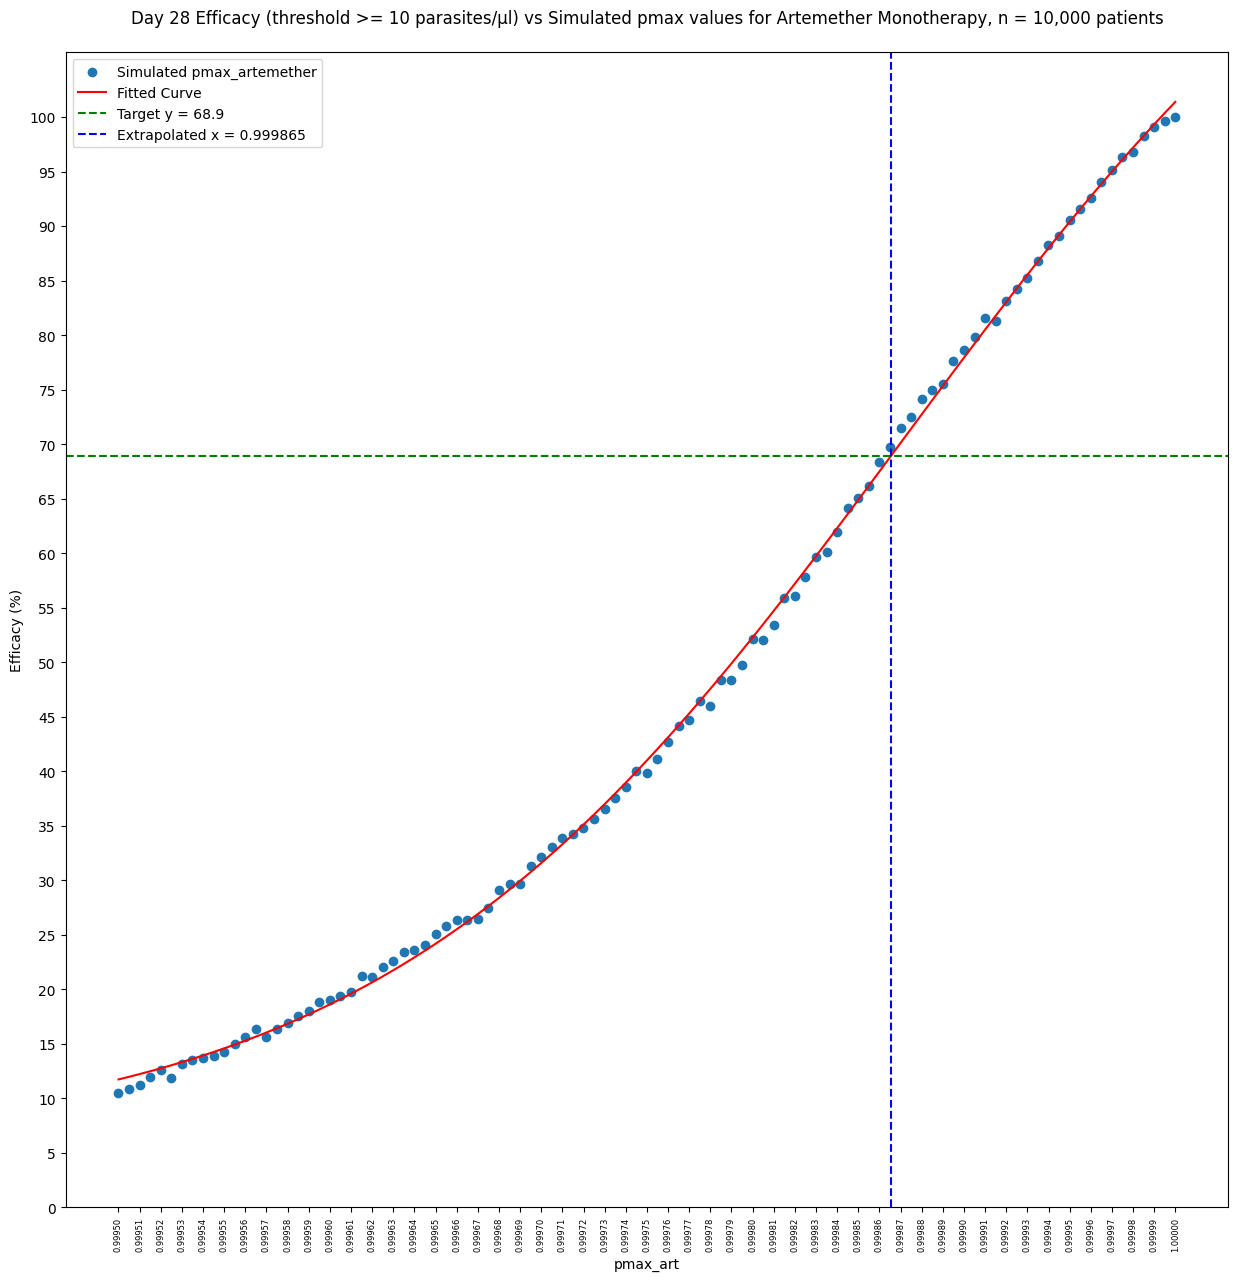

In [409]:
# Plot results
plt.figure(figsize=(15, 15))
plt.scatter(xdata, ydata, label='Simulated pmax_artemether')
plt.plot(xdata, fitted_values, label='Fitted Curve', color='red')
plt.axhline(y=y_target, color='green', linestyle='--', label=f'Target y = {y_target}')
plt.axvline(x=x_target, color='blue', linestyle='--', label=f'Extrapolated x = {x_target:.6f}')
plt.xticks(np.arange(min(xdata), max(xdata)+0.000001,0.00001), rotation = 90)  # Adjust tick marks if necessary
plt.tick_params(axis='x', which='major', labelsize=6)
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.xlabel("pmax_art")
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated pmax values for Artemether Monotherapy, n = 10,000 patients\n")
plt.legend()
plt.savefig(f"pkpd_AL_{file_suffix}_sigmoid.png")
plt.show()

<br>

# Using ```pmax_artemether = 0.99987``` to check if AL PKPD model with ```pkpd_lum = 0``` gives efficacy of 68.9%

<br>

In [ ]:
# Function to run a single simulation for a given weight value

def run_single_weight_simulation(weight):
    start_time = time.monotonic()
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "1000",
        "--weight", str(weight),
        "--pmax_artemether", "0.9998618677625",
        "--pmax_lum", "0",
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split() for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        
        end_time = time.monotonic()
        today = datetime.date.today()
        print("\nToday's date: ", today, "\n")
        print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

        return efficacy, df_weight, failed_treatment_count
        
    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

In [420]:
# Define the weight values to use
#weight_values = [10, 15, 20, 30, 40, 50]
weight_values = [54]

# File suffix for saving results
experiment = "01"
file_suffix = f"artemether_monotherapy_calibration_adjusted_{experiment}"

for weight in weight_values:

        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg_{file_suffix}.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg_{file_suffix}.csv", index=False)

        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")



Today's date:  2025-06-05 

Length of simulation:  0:00:26.217260 


The failed treatment count for weight 54kg is: 316

The percentage efficacy for weight 54kg is: 68.4 

